In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
#Read the saved object:
#Now, h5 class can easily convert it to categoricals. 
dec_results= "/dh-projects/preeclampsia_2022/analysis/placenta_atlas_2022/decidua_anndata/SP014_SP136_decidua_analysis_040322.h5ad"
ldata_dec01= sc.read_h5ad(dec_results)
ldata_dec01

AnnData object with n_obs × n_vars = 66100 × 6000
    obs: 'donor_id', 'time', 'disease', 'tissue', 'smoking', 'cohort', 'library', 'procurement', 'placental_volume', 'gestational_weeks', 'gestational_days', 'maternal_BMI', 'maternal_age', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_MT_genes', 'log1p_total_counts_MT_genes', 'pct_counts_MT_genes', 'total_counts_Ribo_genes', 'log1p_total_counts_Ribo_genes', 'pct_counts_Ribo_genes', 'total_counts_HB_genes', 'log1p_total_counts_HB_genes', 'pct_counts_HB_genes', 'percent_mt2', 'n_counts', 'percent_Ribo2', 'percent_HB2', 'n_genes', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'celltypist_majority_voting', 'celltypist_predicted_labels', 'donor_id_reordered', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'majority_voting', 'predicted_labels', 'conf_score', 'over_clustering', 'leiden', '_scvi_raw_norm_scaling', 'leiden_res1.5', 'leiden_res2', 'dMSC_leiden', 'celltyp

In [4]:
ldata_dec01.obs['celltype_v5'].cat.categories

Index(['DSC1', 'DSC2', 'IL17RA_dMAC3', 'NKT', 'dDC', 'dEVT', 'dEpC', 'dFB1',
       'dFB2', 'dGranul_new', 'dGranulocyte', 'dLEC', 'dLECp', 'dMAC1',
       'dMAC2', 'dMSC', 'dMono_LYZ', 'dNK1', 'dNK2', 'dNK_prol',
       'dPlasma_cell', 'dSMC', 'dTcell', 'dVEC', 'deported_SCT'],
      dtype='object')

In [ ]:
#Hex codes: 
['#33ccff', '#cc3300', '#ccffcc', '#334d4d', '#003366', 
    '#330000','#e6b3e6', '#ffcc99', '#994d00', '#f2e6ff', '#c65353', '#ff66b3', '#99004d',
    '#b3b300', '#4d4d00', '#664400', '#004d00', '#006699', '#80d4ff', '#001a13', '#990000', 
    '#000080', '#c2d6d6', '#9966ff', '#660080']

In [5]:
#Look here: Placenta_atlas_umap_250322.ipynb 
sc.settings.set_figure_params(dpi=150, dpi_save=180, vector_friendly=True, transparent=True)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (3,3) #to make it consistent with villi figure. 
plt.rcParams["axes.grid"] = False

In [6]:
ldata_dec01.obs['n_genes_by_counts']= ldata_dec01.obs['n_genes_by_counts'].astype(np.float)
ldata_dec01.obs['total_counts']= ldata_dec01.obs['total_counts'].astype(np.float)

ldata_v3= ldata_dec01[ldata_dec01.obs['library']== '10X v3']
ldata_v2= ldata_dec01[ldata_dec01.obs['library']== '10X v2']

print(ldata_v2[ldata_v2.obs['time']== 'early'].obs['n_genes_by_counts'].median())
print(ldata_v2[ldata_v2.obs['time']== 'early'].obs['total_counts'].median()) 

1248.0
1661.0


In [7]:
print(ldata_v2[ldata_v2.obs['time']== 'late_preterm'].obs['n_genes_by_counts'].median()) 
print(ldata_v3[ldata_v3.obs['time']== 'late_preterm'].obs['n_genes_by_counts'].median()) 

731.0
1887.0


In [8]:
#Rename dGranul_new to dBeclls: 
ldata_dec01.obs['celltype_v5']= ldata_dec01.obs['celltype_v5'].map(lambda x: {"dGranul_new": "dBcells"}.get(x, x)).astype("category")

ldata_dec01.uns['celltype_v5_colors']= ['#33ccff', '#cc3300', '#ccffcc', '#334d4d', '#003366', 
    '#330000','#e6b3e6', '#ffcc99', '#994d00', '#f2e6ff', '#c65353', '#ff66b3', '#99004d',
    '#b3b300', '#4d4d00', '#664400', '#004d00', '#006699', '#80d4ff', '#001a13', '#990000', 
    '#000080', '#c2d6d6', '#9966ff', '#660080']

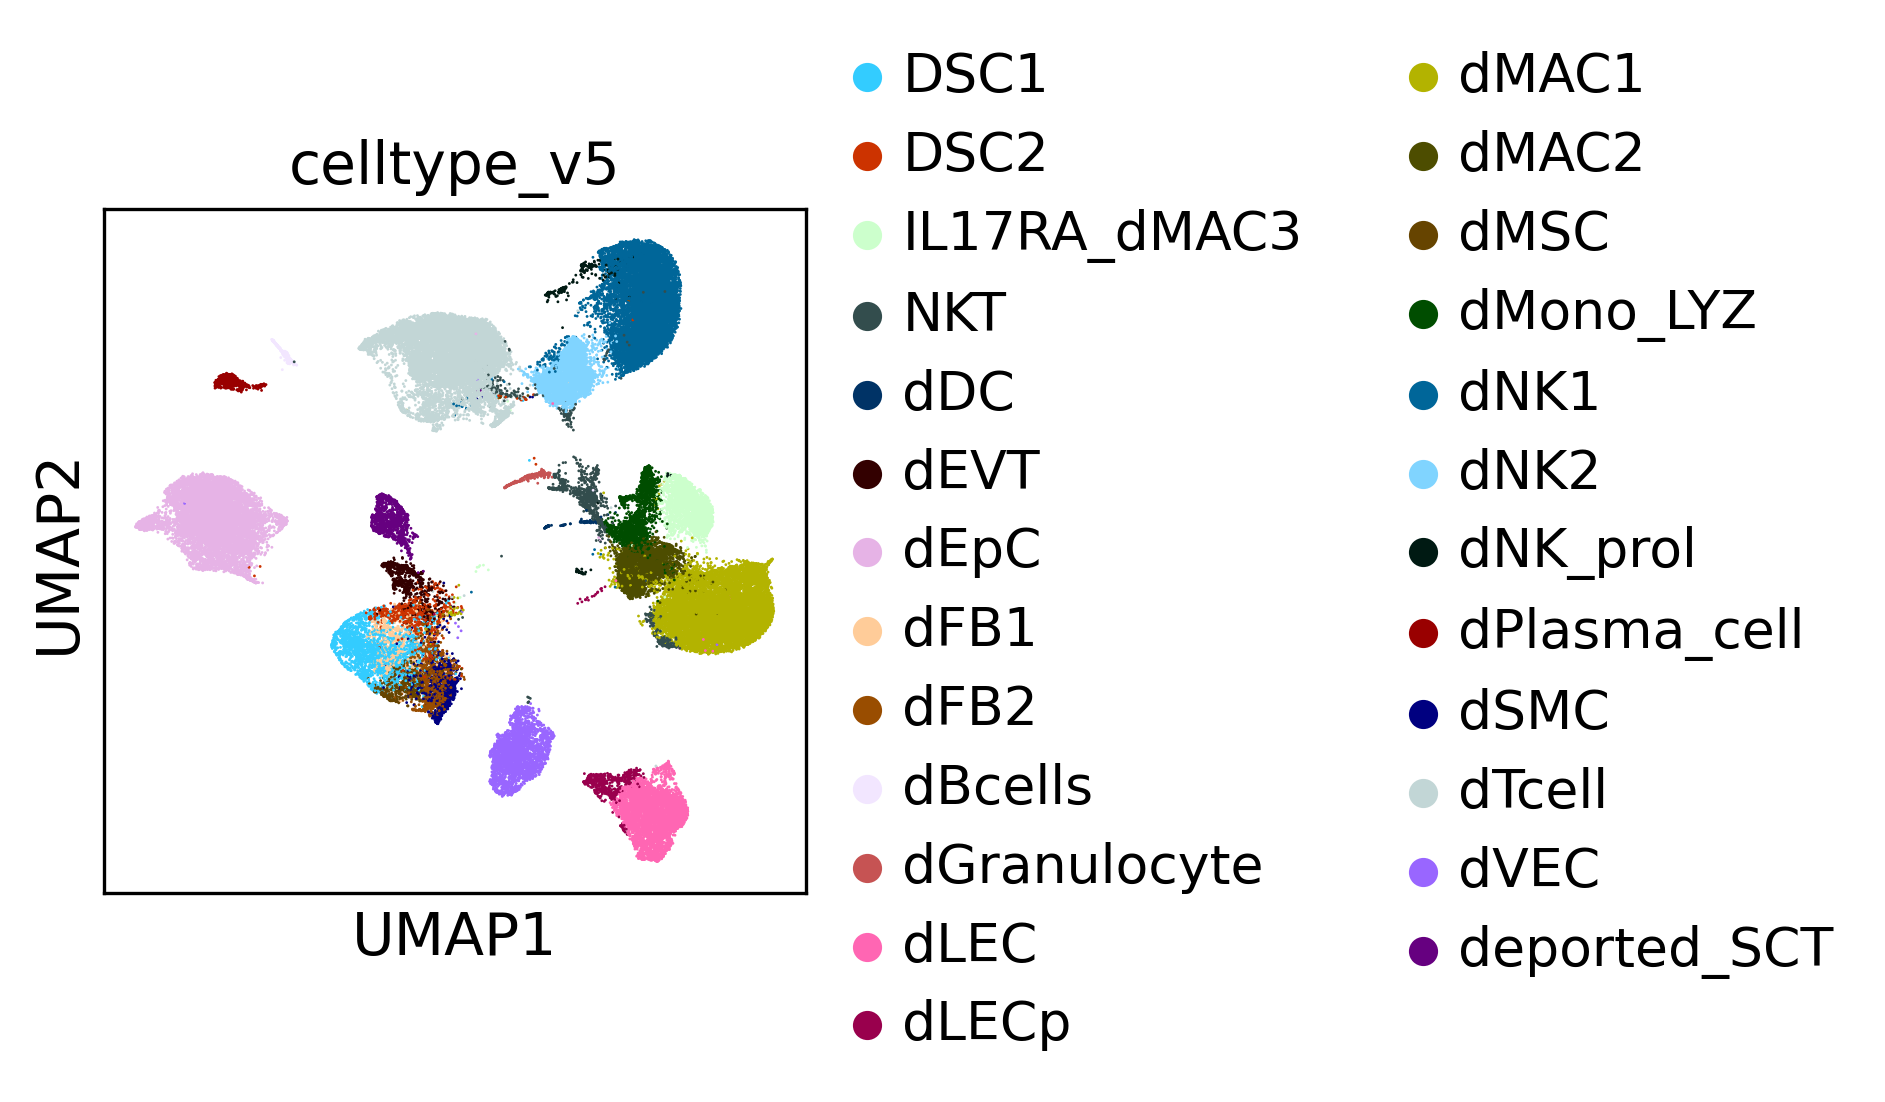

In [9]:
sc.pl.umap(ldata_dec01, color= ['celltype_v5'])

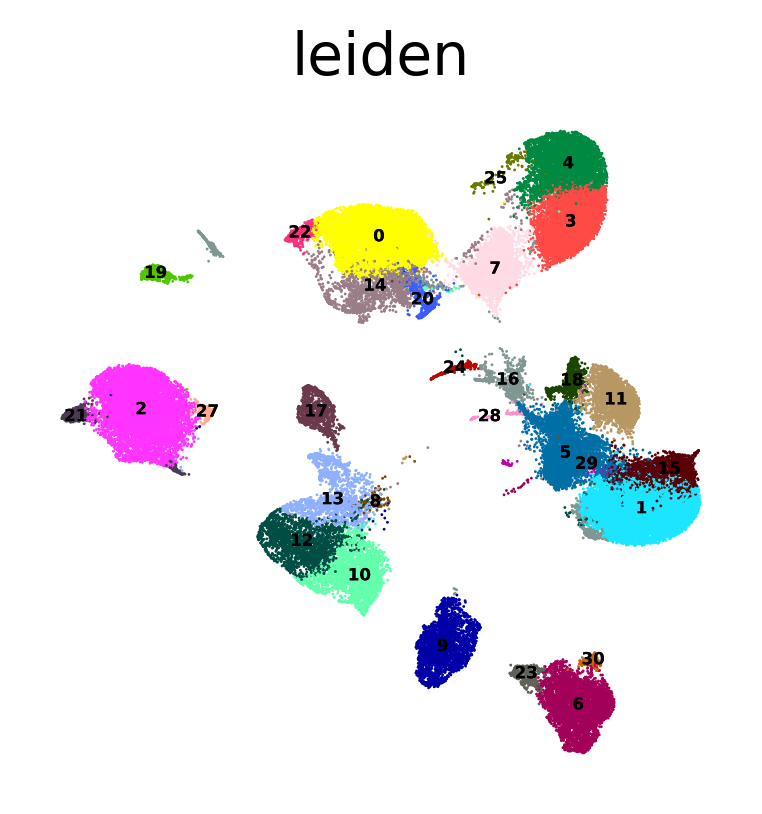

In [10]:
sc.pl.umap(ldata_dec01, color= ['leiden'], legend_loc='on data',
           legend_fontoutline=0, 
           frameon=False, legend_fontsize=4)

In [11]:
#Select NKC & MAC gene markers: 
nkt_mac_genes= ['CD96', 'NKG7', 'IL2RB', 'NCAM1', 'GNLY', 'CTSW', 'PRF1', 
              'ITGAD', 'STYK1', 'KLRF2',  'THEMIS', 'CCL5', 'CD3D', 'CD3E', 'CD8A', 'CD3G', 'CD8B', 
             'IL7R', 'CD6', 'MS4A6A', 'SPP1', 'VSIG4', 'MRC1', 'CD163', 'MAF', 'LYVE1', 'F13A1', 'RBPJ', 'SELENOP']


#Calculate average gene expression per cell type group: 
#This is mainly to look at clusters harboring both NK/MAC: 
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out


#Select the immune subsets: 
subset= ['dNK1', 'dNK2', 'NKT', 'dTcell', 'dMAC1', 'dMAC2']
dec_immune= ldata_dec01[ldata_dec01.obs['celltype_v5'].isin(subset)]
dec_immune.obs['celltype_v5'].value_counts()

dTcell    10505
dMAC1     10098
dNK1       9682
dNK2       3531
dMAC2      2897
NKT        1119
Name: celltype_v5, dtype: int64

In [12]:
ldata_norm_int= dec_immune.raw.to_adata()

#Normalize:
sc.pp.normalize_total(ldata_norm_int, target_sum=1e4)
sc.pp.log1p(ldata_norm_int)

#Print the mean gene counts per cell groups:
grouped_obs_mean(ldata_norm_int[:, nkt_mac_genes], group_key= 'celltype_v5')

NKT     dMAC1     dMAC2      dNK1      dNK2    dTcell
CD96     0.910168  0.030709  0.008365  2.249302  2.124703  1.742726
NKG7     0.264764  0.012473  0.016449  1.087526  0.789771  0.429288
IL2RB    0.312318  0.014812  0.013148  1.088719  0.829098  0.322385
NCAM1    0.801131  0.028502  0.015404  2.826349  1.842601  0.189885
GNLY     1.134393  0.133469  0.073188  3.029001  1.322811  0.467214
CTSW     0.436007  0.015661  0.011388  2.066805  0.844089  0.417580
PRF1     0.131594  0.005485  0.000738  0.445824  0.315506  0.254739
ITGAD    0.398363  0.128248  0.036277  2.363213  0.407008  0.042121
STYK1    0.167103  0.006891  0.000738  0.768904  0.174439  0.066206
KLRF2    0.126135  0.003029  0.000000  0.858473  0.221839  0.031228
THEMIS   0.504348  0.016138  0.008072  0.557250  0.363510  1.882538
CCL5     0.298098  0.018902  0.009008  0.374856  1.225263  0.899057
CD3D     0.068695  0.002801  0.000000  0.035137  0.076363  0.585312
CD3E     0.093023  0.004919  0.002305  0.137724  0.099782  0.458598
CD8A     0.031895  0.001072  0.000344  0.011209  0.051090  0.249730
CD3G     0.062261  0.002899  0.000584  0.013124  0.057828  0.498253
CD8B     0.041123  0.001666  0.000942  0.008418  0.033979  0.240614
IL7R     0.248670  0.025644  0.056798  0.021991  0.058168  0.810660
CD6      0.129592  0.026727  0.023679  0.022083  0.104950  0.626513
MS4A6A   0.921972  2.084259  1.234457  0.010838  0.003526  0.015492
SPP1     0.380340  1.124508  1.190105  0.007153  0.002607  0.012386
VSIG4    0.442754  1.340566  0.751044  0.006866  0.003681  0.009118
MRC1     0.831007  2.140266  1.259389  0.012856  0.012468  0.016443
CD163    0.634861  1.660947  1.034297  0.005136  0.005714  0.012353
MAF      0.421986  0.967513  0.518469  0.016362  0.032363  0.303478
LYVE1    0.143910  0.371681  0.114999  0.008045  0.004112  0.009130
F13A1    1.104968  2.565268  1.629093  0.025995  0.012529  0.020780
RBPJ     1.781720  2.762430  2.932273  0.691902  0.690543  0.646813
SELENOP  0.757641  2.102878  1.316900  0.014084  0.006885  0.016788

         Falling back to preprocessing with `sc.pp.pca` and default params.


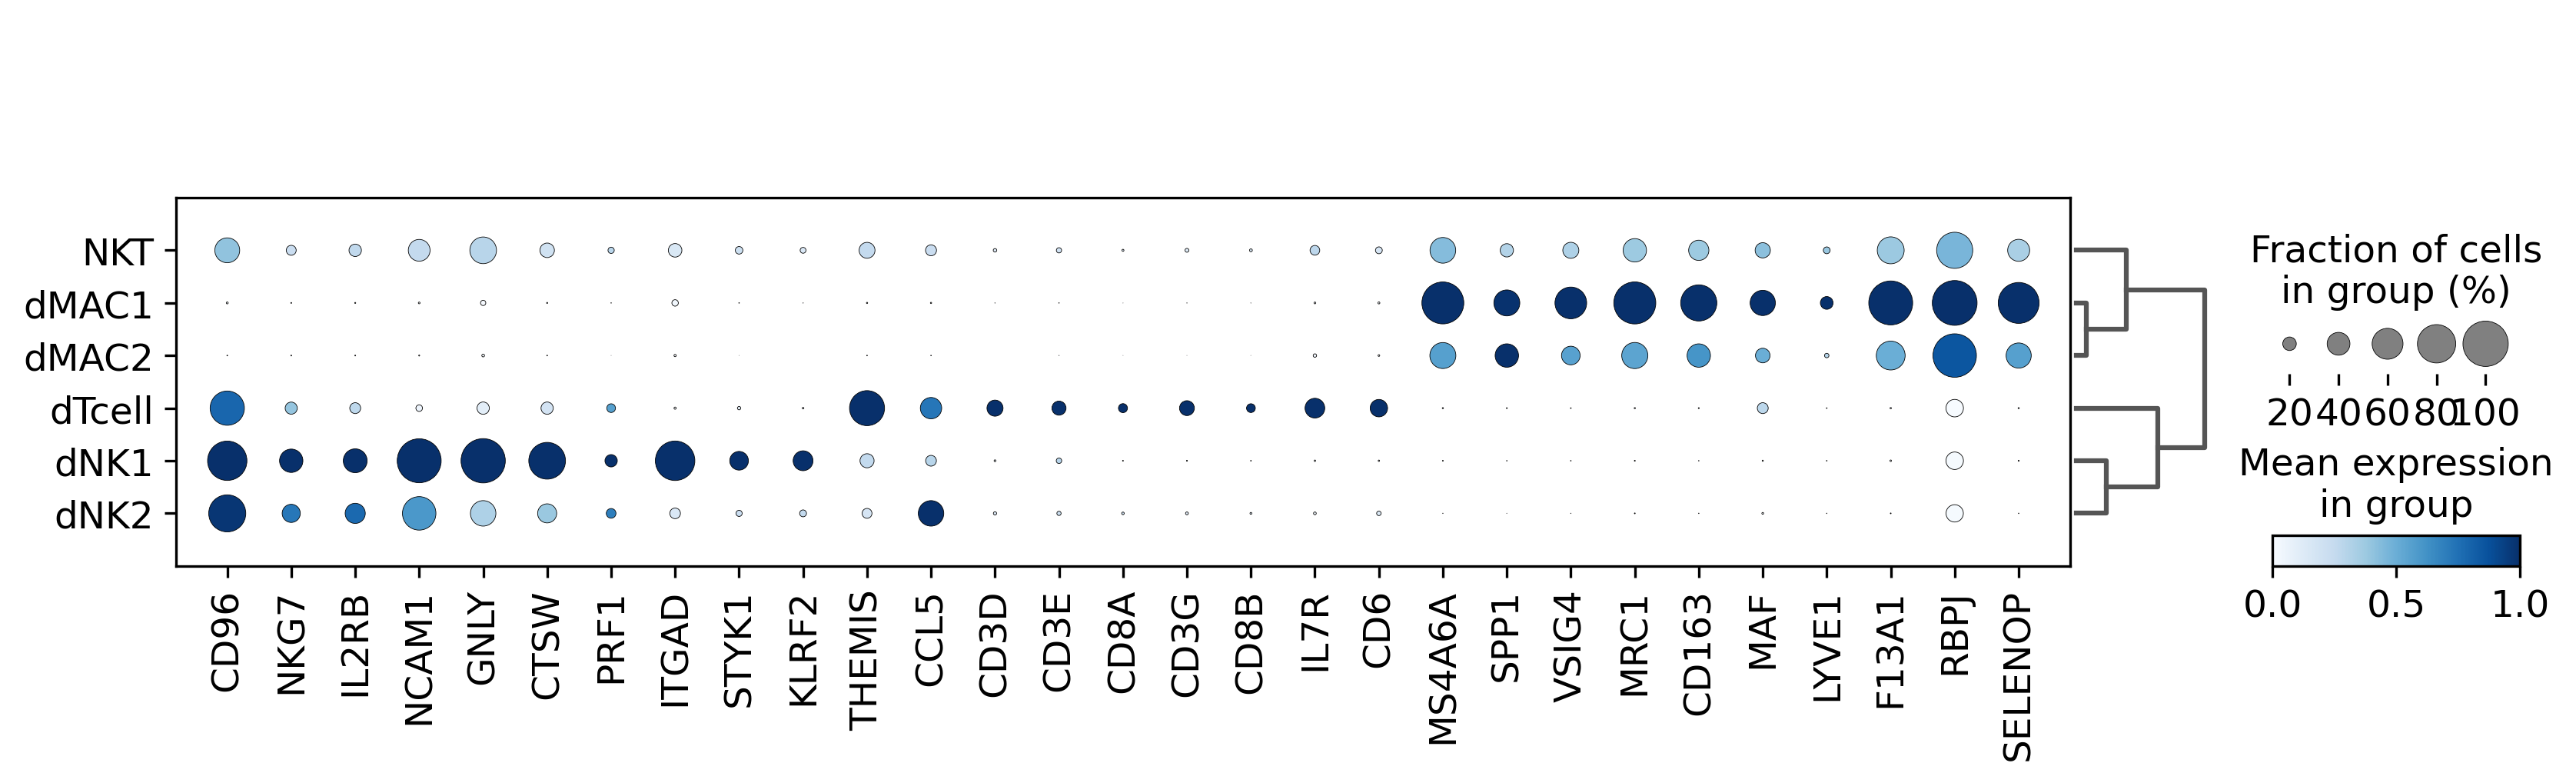

In [13]:
sc.tl.dendrogram(dec_immune, groupby= 'celltype_v5') 
              
#NKT is an ambiguous cluster expressing both lymphoid & myeloid cell markers. 
sc.pl.dotplot(dec_immune, nkt_mac_genes, groupby= 'celltype_v5', dendrogram=True,
    color_map="Blues", use_raw=True, standard_scale="var") 

#grouped_obs_mean(ldata_norm_int[:, nkt_mac_genes], group_key= 'celltype_v5').to_csv('NKT_mean_gene_exp_110422.csv')

In [14]:
ldata_dec01.obs['leiden'].value_counts()

0     8097
1     8060
2     7230
3     4955
4     4683
5     4226
6     4167
7     3650
9     2760
10    2689
11    2343
12    2109
13    1647
14    1622
15    1586
16    1202
17    1065
18     755
19     552
20     500
21     402
22     374
23     320
24     275
25     199
27     176
28     128
29     126
30     109
8       93
Name: leiden, dtype: int64

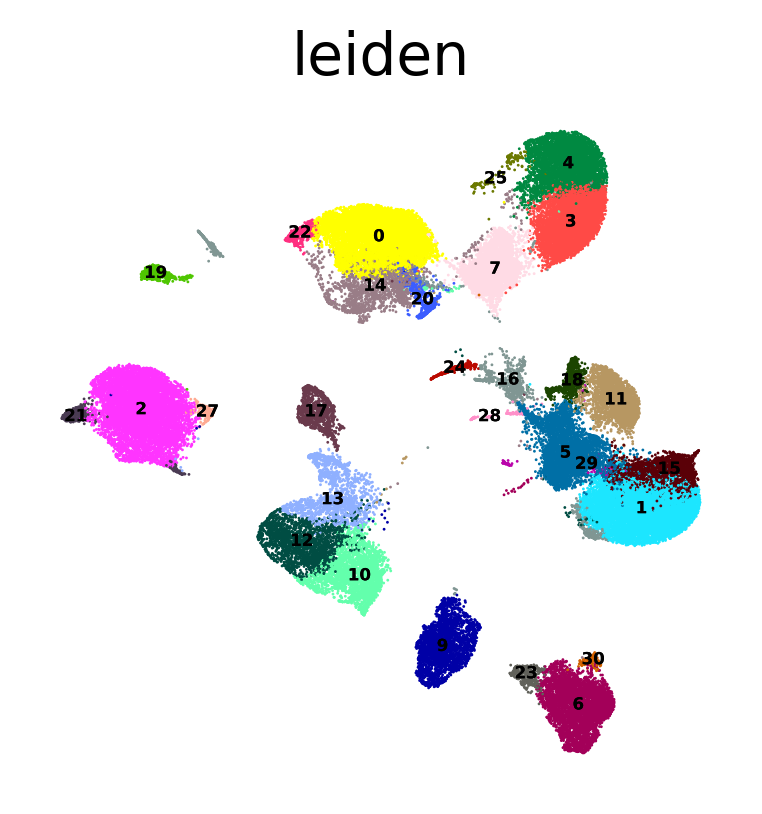

In [15]:
#Remove leiden-8 (n=93 cells; contaminating dEVT, stromal & MAC genes intermingling close to DSC2):
ldata_filter= ldata_dec01[ldata_dec01.obs['leiden']!= '8']

sc.pl.umap(ldata_filter, color= ['leiden'], legend_loc='on data',
           legend_fontoutline=0, 
           frameon=False, legend_fontsize=4)

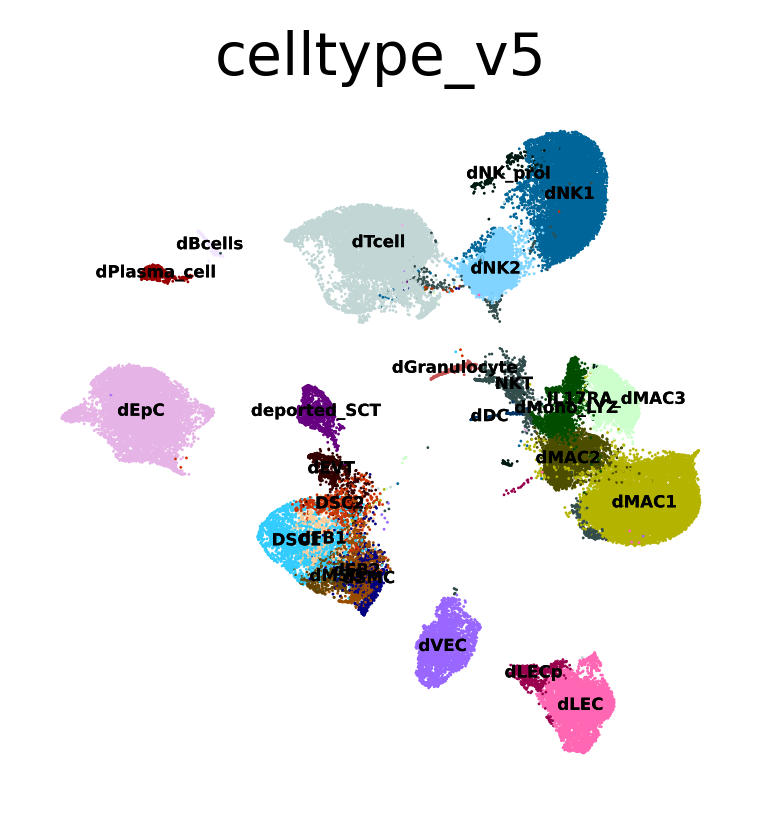

In [16]:
sc.pl.umap(ldata_filter, color= ['celltype_v5'], legend_loc='on data',
           legend_fontoutline=0, 
           frameon=False, legend_fontsize=4)

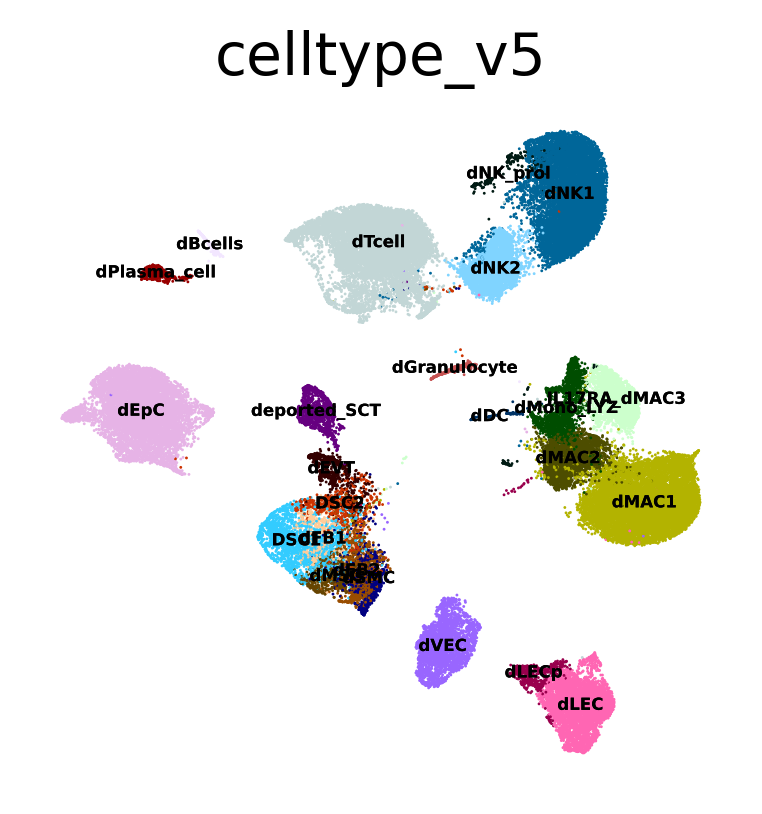

In [17]:
#Filter out the ambiguous NKT cell group: 
ldata_filter02= ldata_filter[ldata_filter.obs['celltype_v5']!= 'NKT']

sc.pl.umap(ldata_filter02, color= ['celltype_v5'], legend_loc='on data',
           legend_fontoutline=0, 
           frameon=False, legend_fontsize=4)

In [18]:
# #sc.tl.leiden(ldata_filter02, resolution=3.5, key_added= 'leiden_res3.5')

# sc.pl.umap(ldata_filter02, color= ['leiden_res3.5'], legend_loc='on data',
#            legend_fontoutline=0, 
#            frameon=False, legend_fontsize=4)

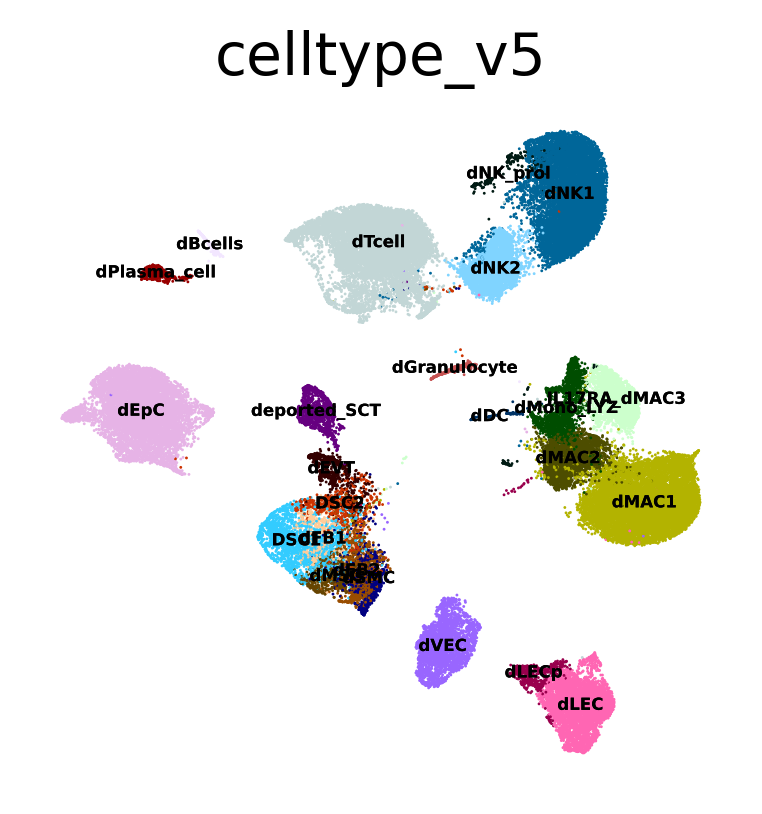

In [19]:
sc.pl.umap(ldata_filter02, color= ['celltype_v5'], legend_loc='on data',
           legend_fontoutline=0, 
           frameon=False, legend_fontsize=4)

Trying to set attribute `.obs` of view, copying.


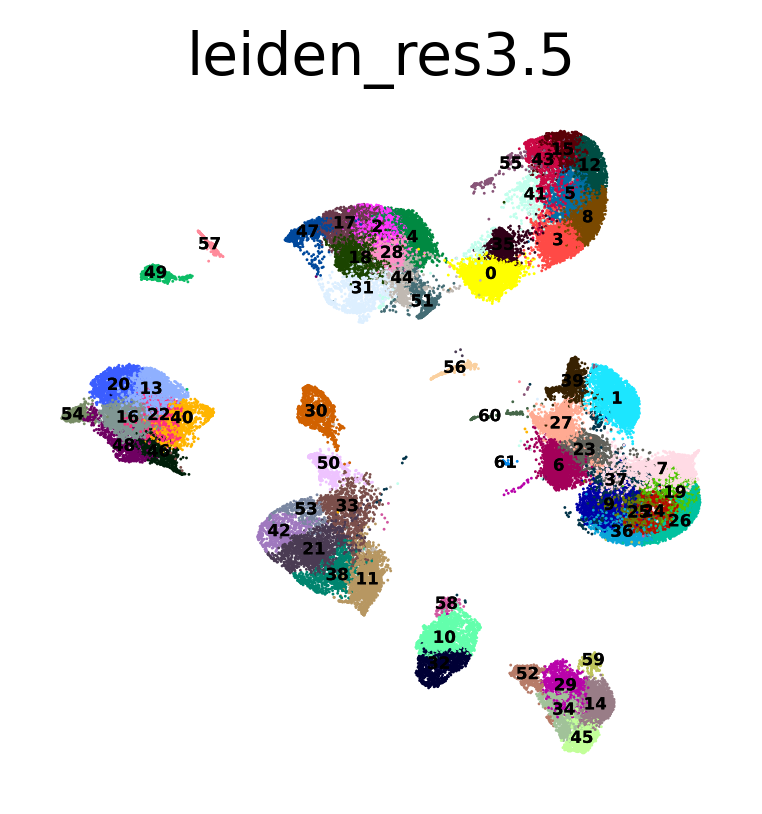

In [20]:
sc.tl.leiden(ldata_filter02, resolution=3.5, key_added= 'leiden_res3.5')

#small cluster 61 (below dDC) is donor-specific & likely a contamination of immune/LEC: 
sc.pl.umap(ldata_filter02, color= ['leiden_res3.5'], legend_loc='on data',
           legend_fontoutline=0, 
           frameon=False, legend_fontsize=4)

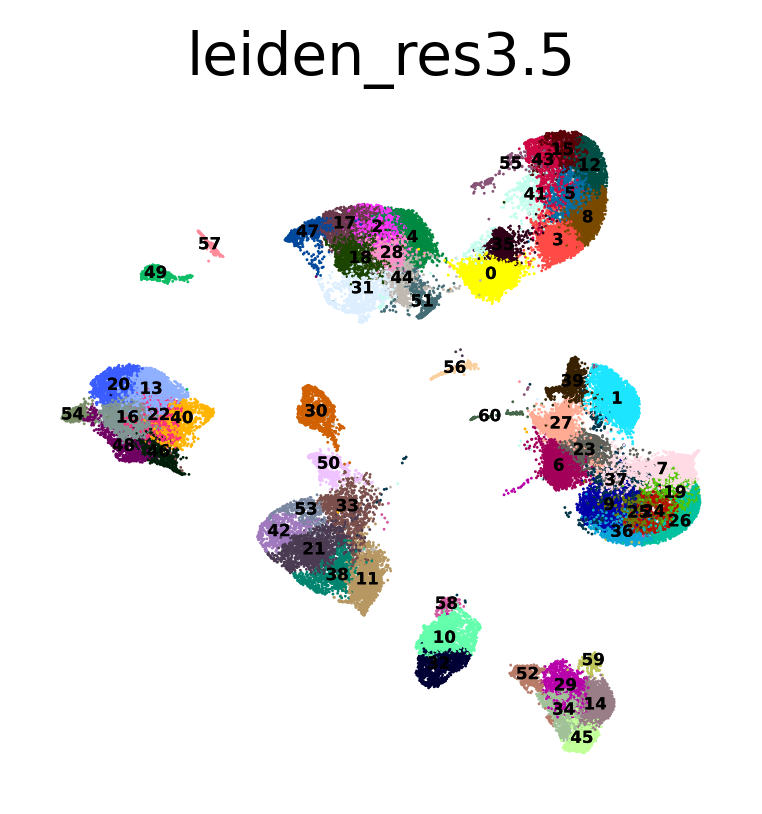

In [21]:
ldata_filter03= ldata_filter02[ldata_filter02.obs['leiden_res3.5']!= '61']

#After removing NKT & small donor cluster 61: 
sc.pl.umap(ldata_filter03, color= ['leiden_res3.5'], legend_loc='on data',
           legend_fontoutline=0, 
           frameon=False, legend_fontsize=4)

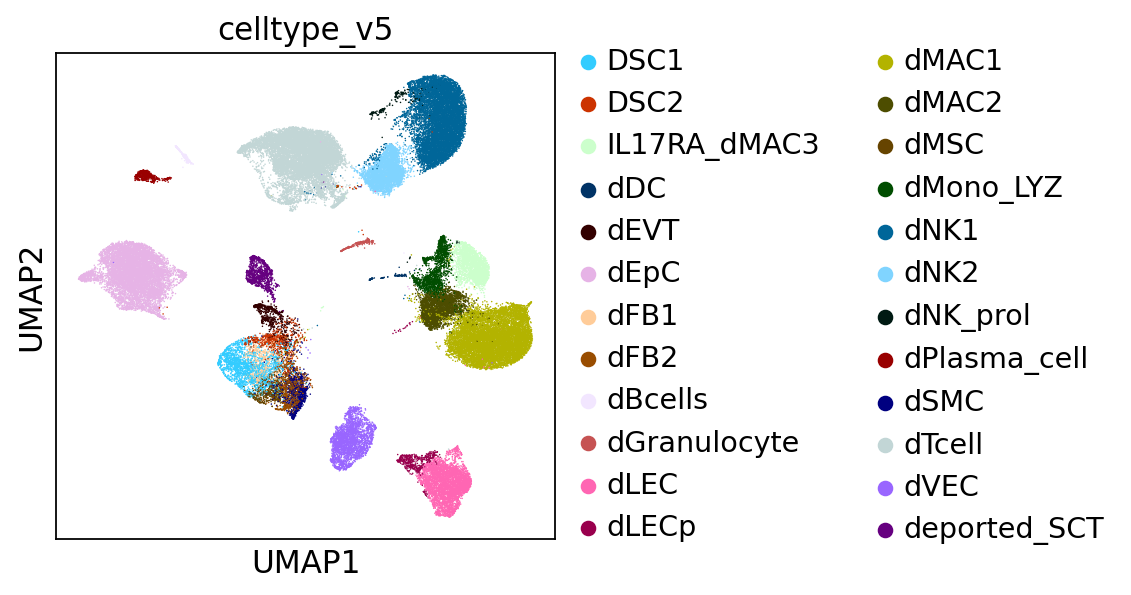

In [23]:
plt.rcParams["figure.figsize"] = (3,3)
sc.settings.set_figure_params(dpi_save=220, vector_friendly=True, transparent=True)

sc.pl.umap(ldata_filter03, color= ['celltype_v5']) #save= 'decidua_atlas_umap_110422.pdf' 

early
late_preterm
late_term


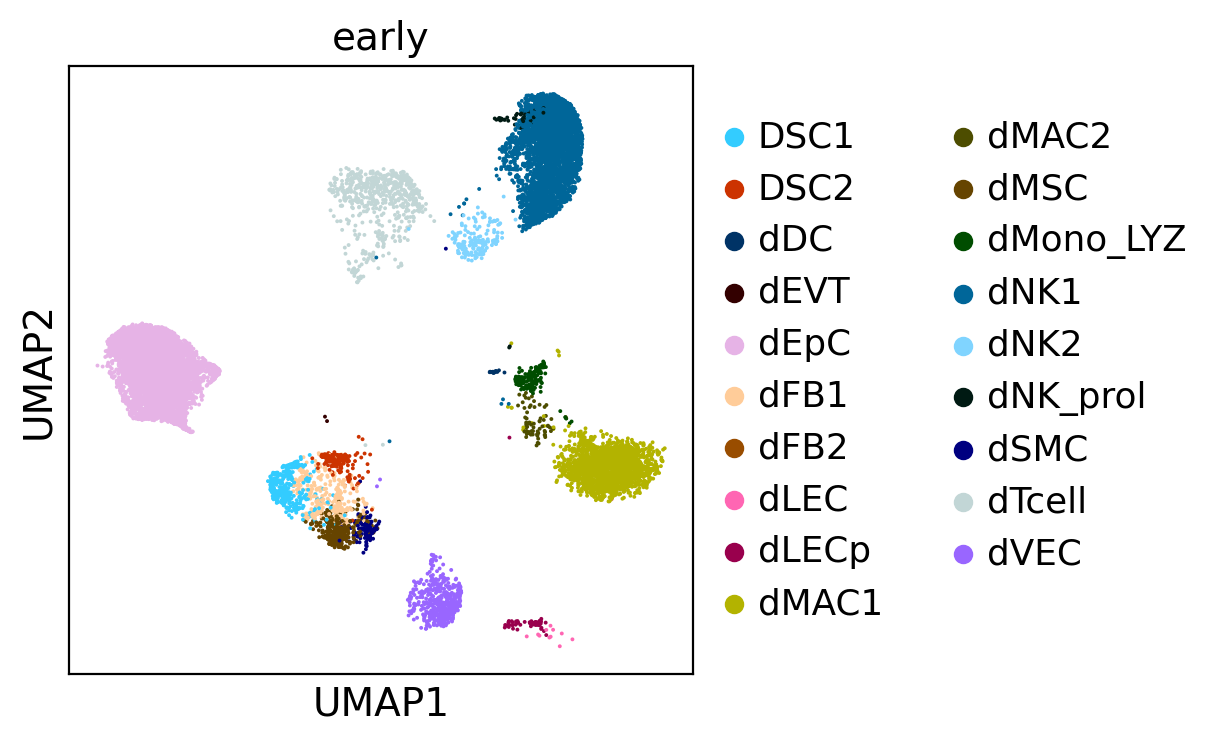

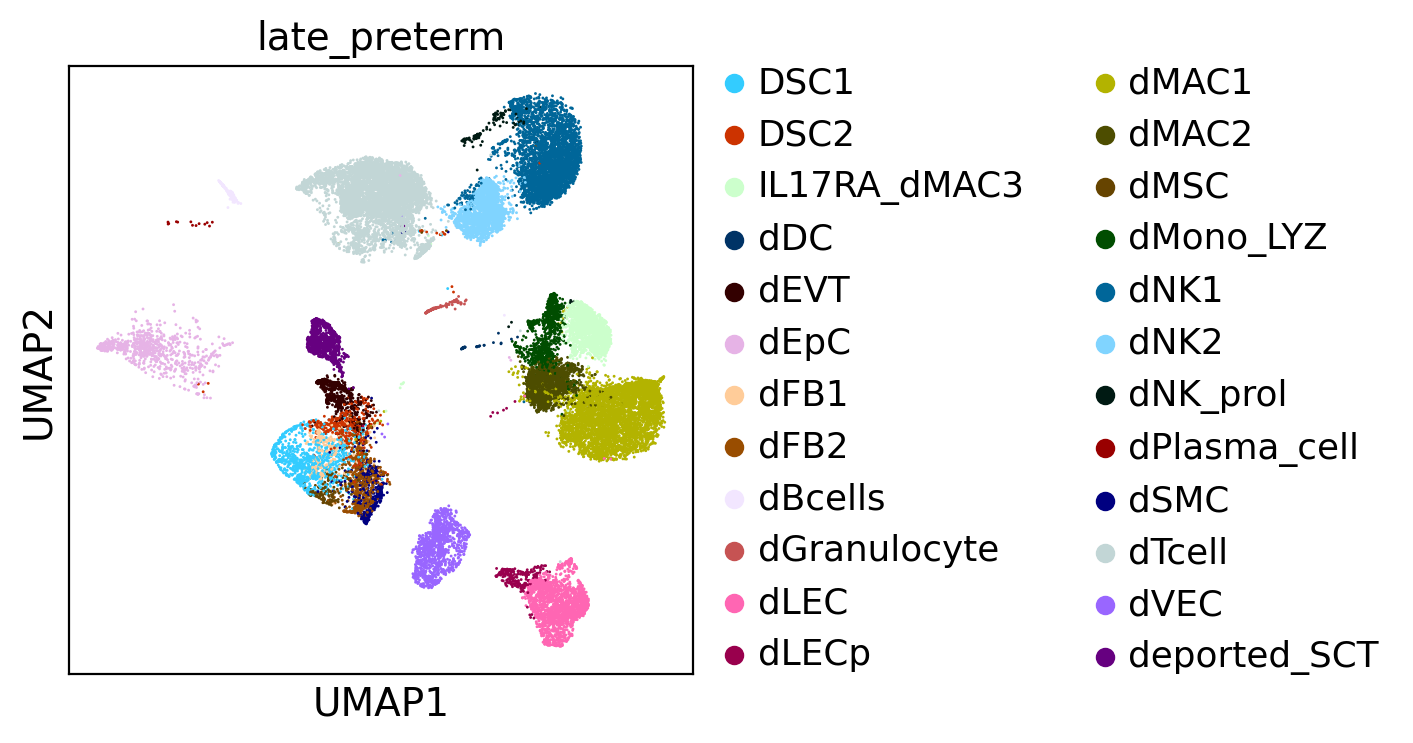

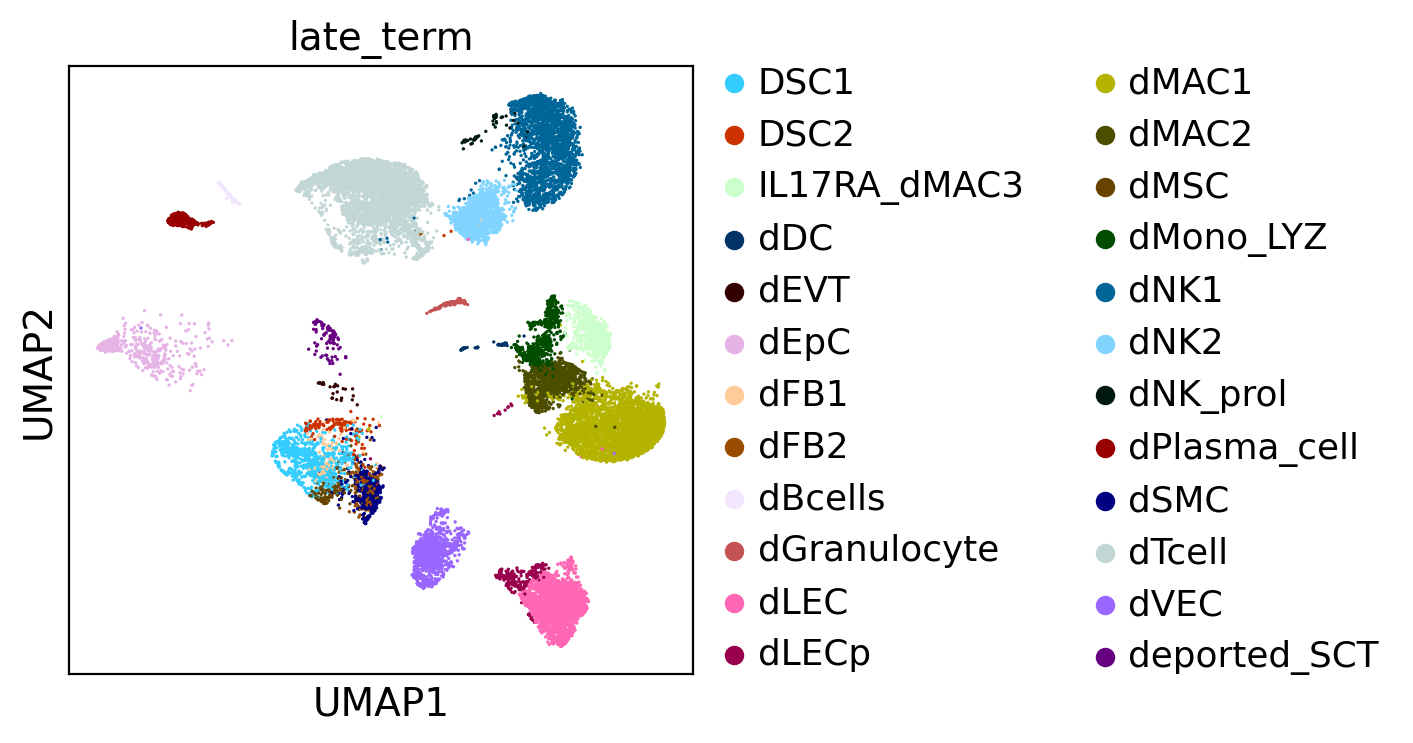

In [24]:
plt.rcParams["figure.figsize"] = (3,3)
sc.settings.set_figure_params(dpi=100, vector_friendly=True, transparent=True)

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf

#Split by gestational time: 
pdf = matplotlib.backends.backend_pdf.PdfPages("Decidua_umap_per_gest_time.pdf")

for i in ldata_filter03.obs['time'].cat.categories:
    print(i) 
    fig= sc.pl.umap(ldata_filter03[ldata_filter03.obs['time'] == i], color = 'celltype_v5', return_fig=True, title= i)
    pdf.savefig(fig)
    
pdf.close() 

Calculate the density of cells in an embedding (per gestational time point).

Gaussian kernel density estimation is used to calculate the density of cells in an embedded space (here, UMAP). This can be performed per category over a categorical cell annotation. Note that density values are scaled to be between 0 and 1- hence, the value at each cell is only comparable to densities in the same category.

Trying to set attribute `.obs` of view, copying.


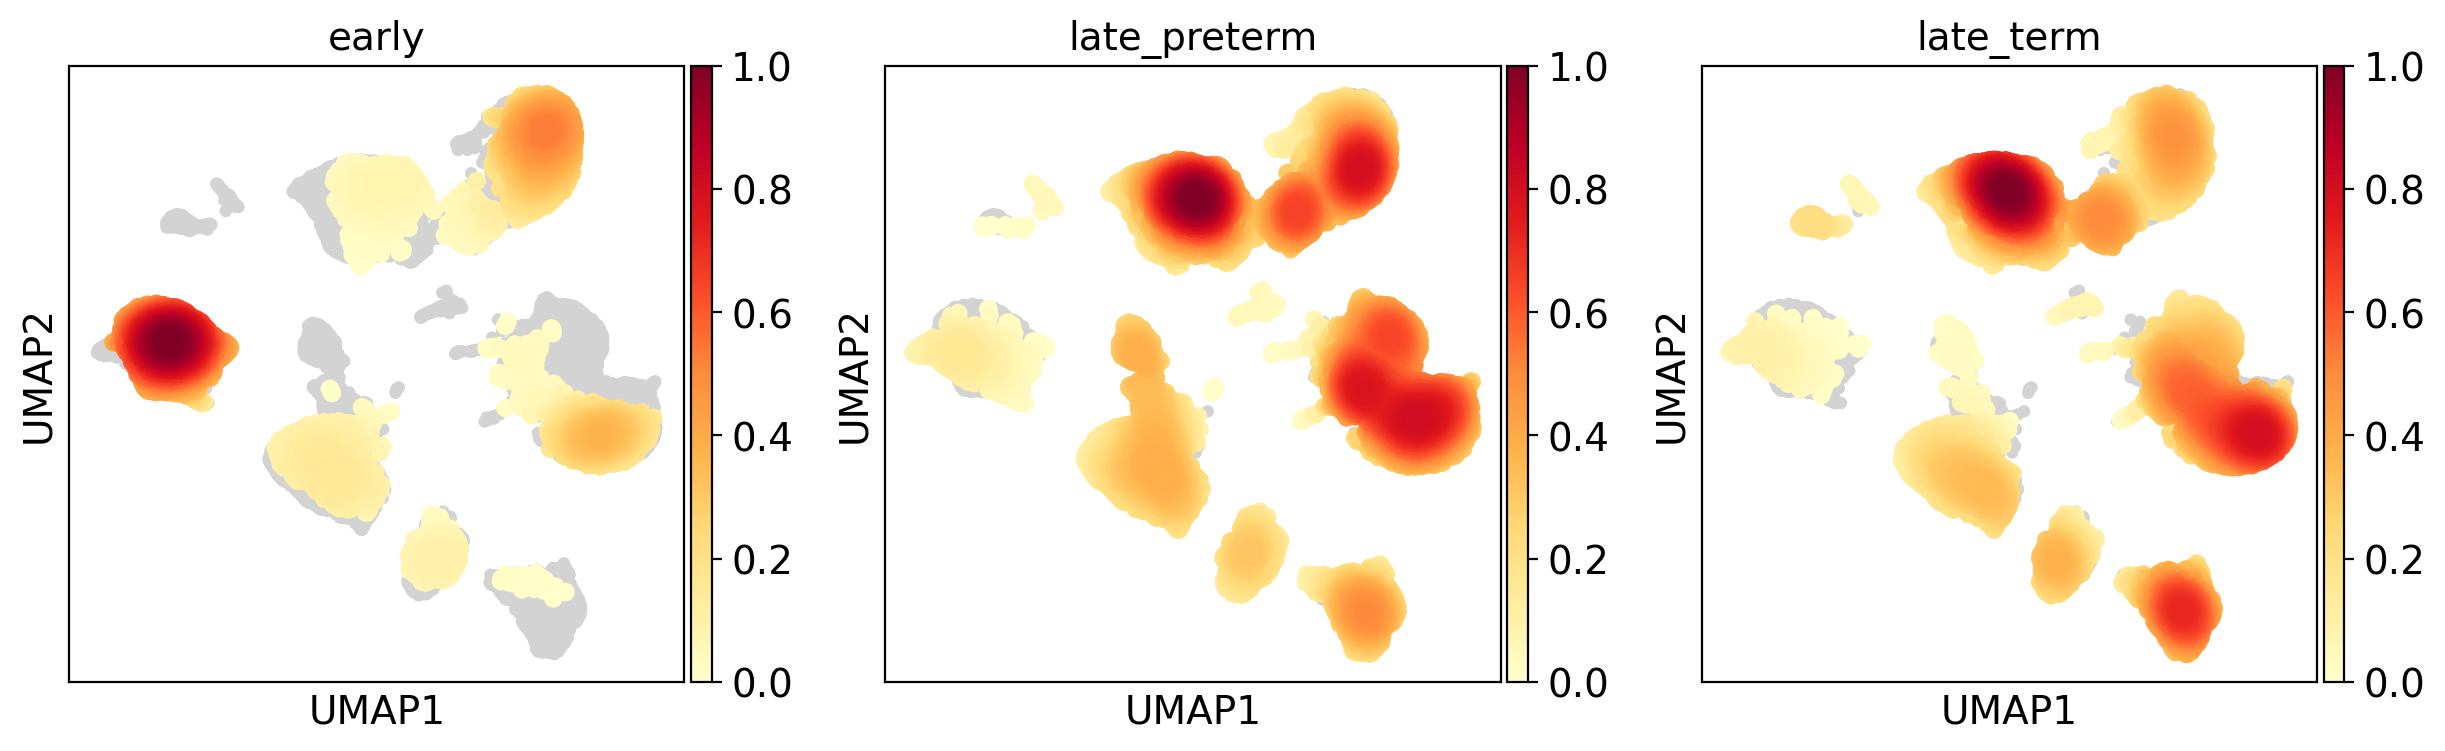

In [25]:
#Extended Data figure 6H: 

#Plot embedding density:
sc.tl.embedding_density(ldata_filter03, basis='umap', groupby= 'time')
sc.pl.embedding_density(ldata_filter03, basis='umap', key='umap_density_time') #save= 'Decidua_KDE_gestation_110422.pdf' 

In [26]:
#Composition analysis: decidua 
#Barplots for each patient & split sample composition as required: such as by "gestation" & "donor_id". 
def make_bar_plots(adata, anno_groupby = 'time',
                         anno_subsets = 'celltype_v5',
                         anno_pointdef = 'time',
                         save_file = 'SP14_SP136_decidua_gestation_composition_v2_110422.pdf'):
    
    #Get number of categories (3 categories: early, late_preterm/PE & term)
    labels = adata.obs[anno_groupby].cat.categories.tolist()
    n_labels = len(labels)
    subset_ids = adata.obs[anno_subsets].cat.categories.tolist()
    n_subsets = len(subset_ids)
    patient_ids = adata.obs[anno_pointdef].cat.categories.tolist()
    n_patients = len(patient_ids)

    ## Calculate subset fractions
    subset_frac = pd.DataFrame(np.empty([n_patients, n_subsets]),
                                    index = patient_ids ,
                                    columns = subset_ids)
    for i in np.arange(n_patients):
        ind2 = adata.obs[anno_pointdef] == patient_ids[i]
        for j in np.arange(n_subsets):
            ind1 = adata.obs[anno_subsets] == subset_ids[j]
            subset_frac.iloc[i,j] = sum(ind1&ind2)
    subset_frac = subset_frac.apply(lambda x: x/sum(x),axis=1)

    ## Get patient labels
    patient_phenos = pd.DataFrame(index = subset_frac.index, columns=[anno_groupby])
    for i in range(0,len(labels)):
        p_list = adata.obs[anno_pointdef][adata.obs[anno_groupby] == labels[i]].unique().tolist()
        patient_phenos[anno_groupby][p_list] = labels[i]
    patient_phenos['time'] = patient_phenos['time'].astype('category')
    patient_phenos['time'] = patient_phenos['time'].cat.reorder_categories(labels)
    ord_ind = patient_phenos.sort_values('time', ascending=False).index

    subset_frac = subset_frac.loc[ord_ind]

    fig, axes = plt.subplots(1,1, figsize=(10,3))

    subset_frac.plot.barh(stacked=True, grid=False, legend=False, ax=axes, color= ['#33ccff', '#cc3300', '#ccffcc', '#003366', '#330000', '#e6b3e6',
       '#ffcc99', '#994d00', '#f2e6ff', '#c65353', '#ff66b3', '#99004d',
       '#b3b300', '#4d4d00', '#664400', '#004d00', '#006699', '#80d4ff',
       '#001a13', '#990000', '#000080', '#c2d6d6', '#9966ff', '#660080'])

    box = axes.get_position()
    axes.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    axes.legend(loc='lower right', bbox_to_anchor=(1.5, 0.5), frameon=True)
    sns.despine(left=True, bottom=True, right=True)
    plt.tight_layout()
    plt.savefig(save_file)

/home/debnatho/anaconda3/envs/scvi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


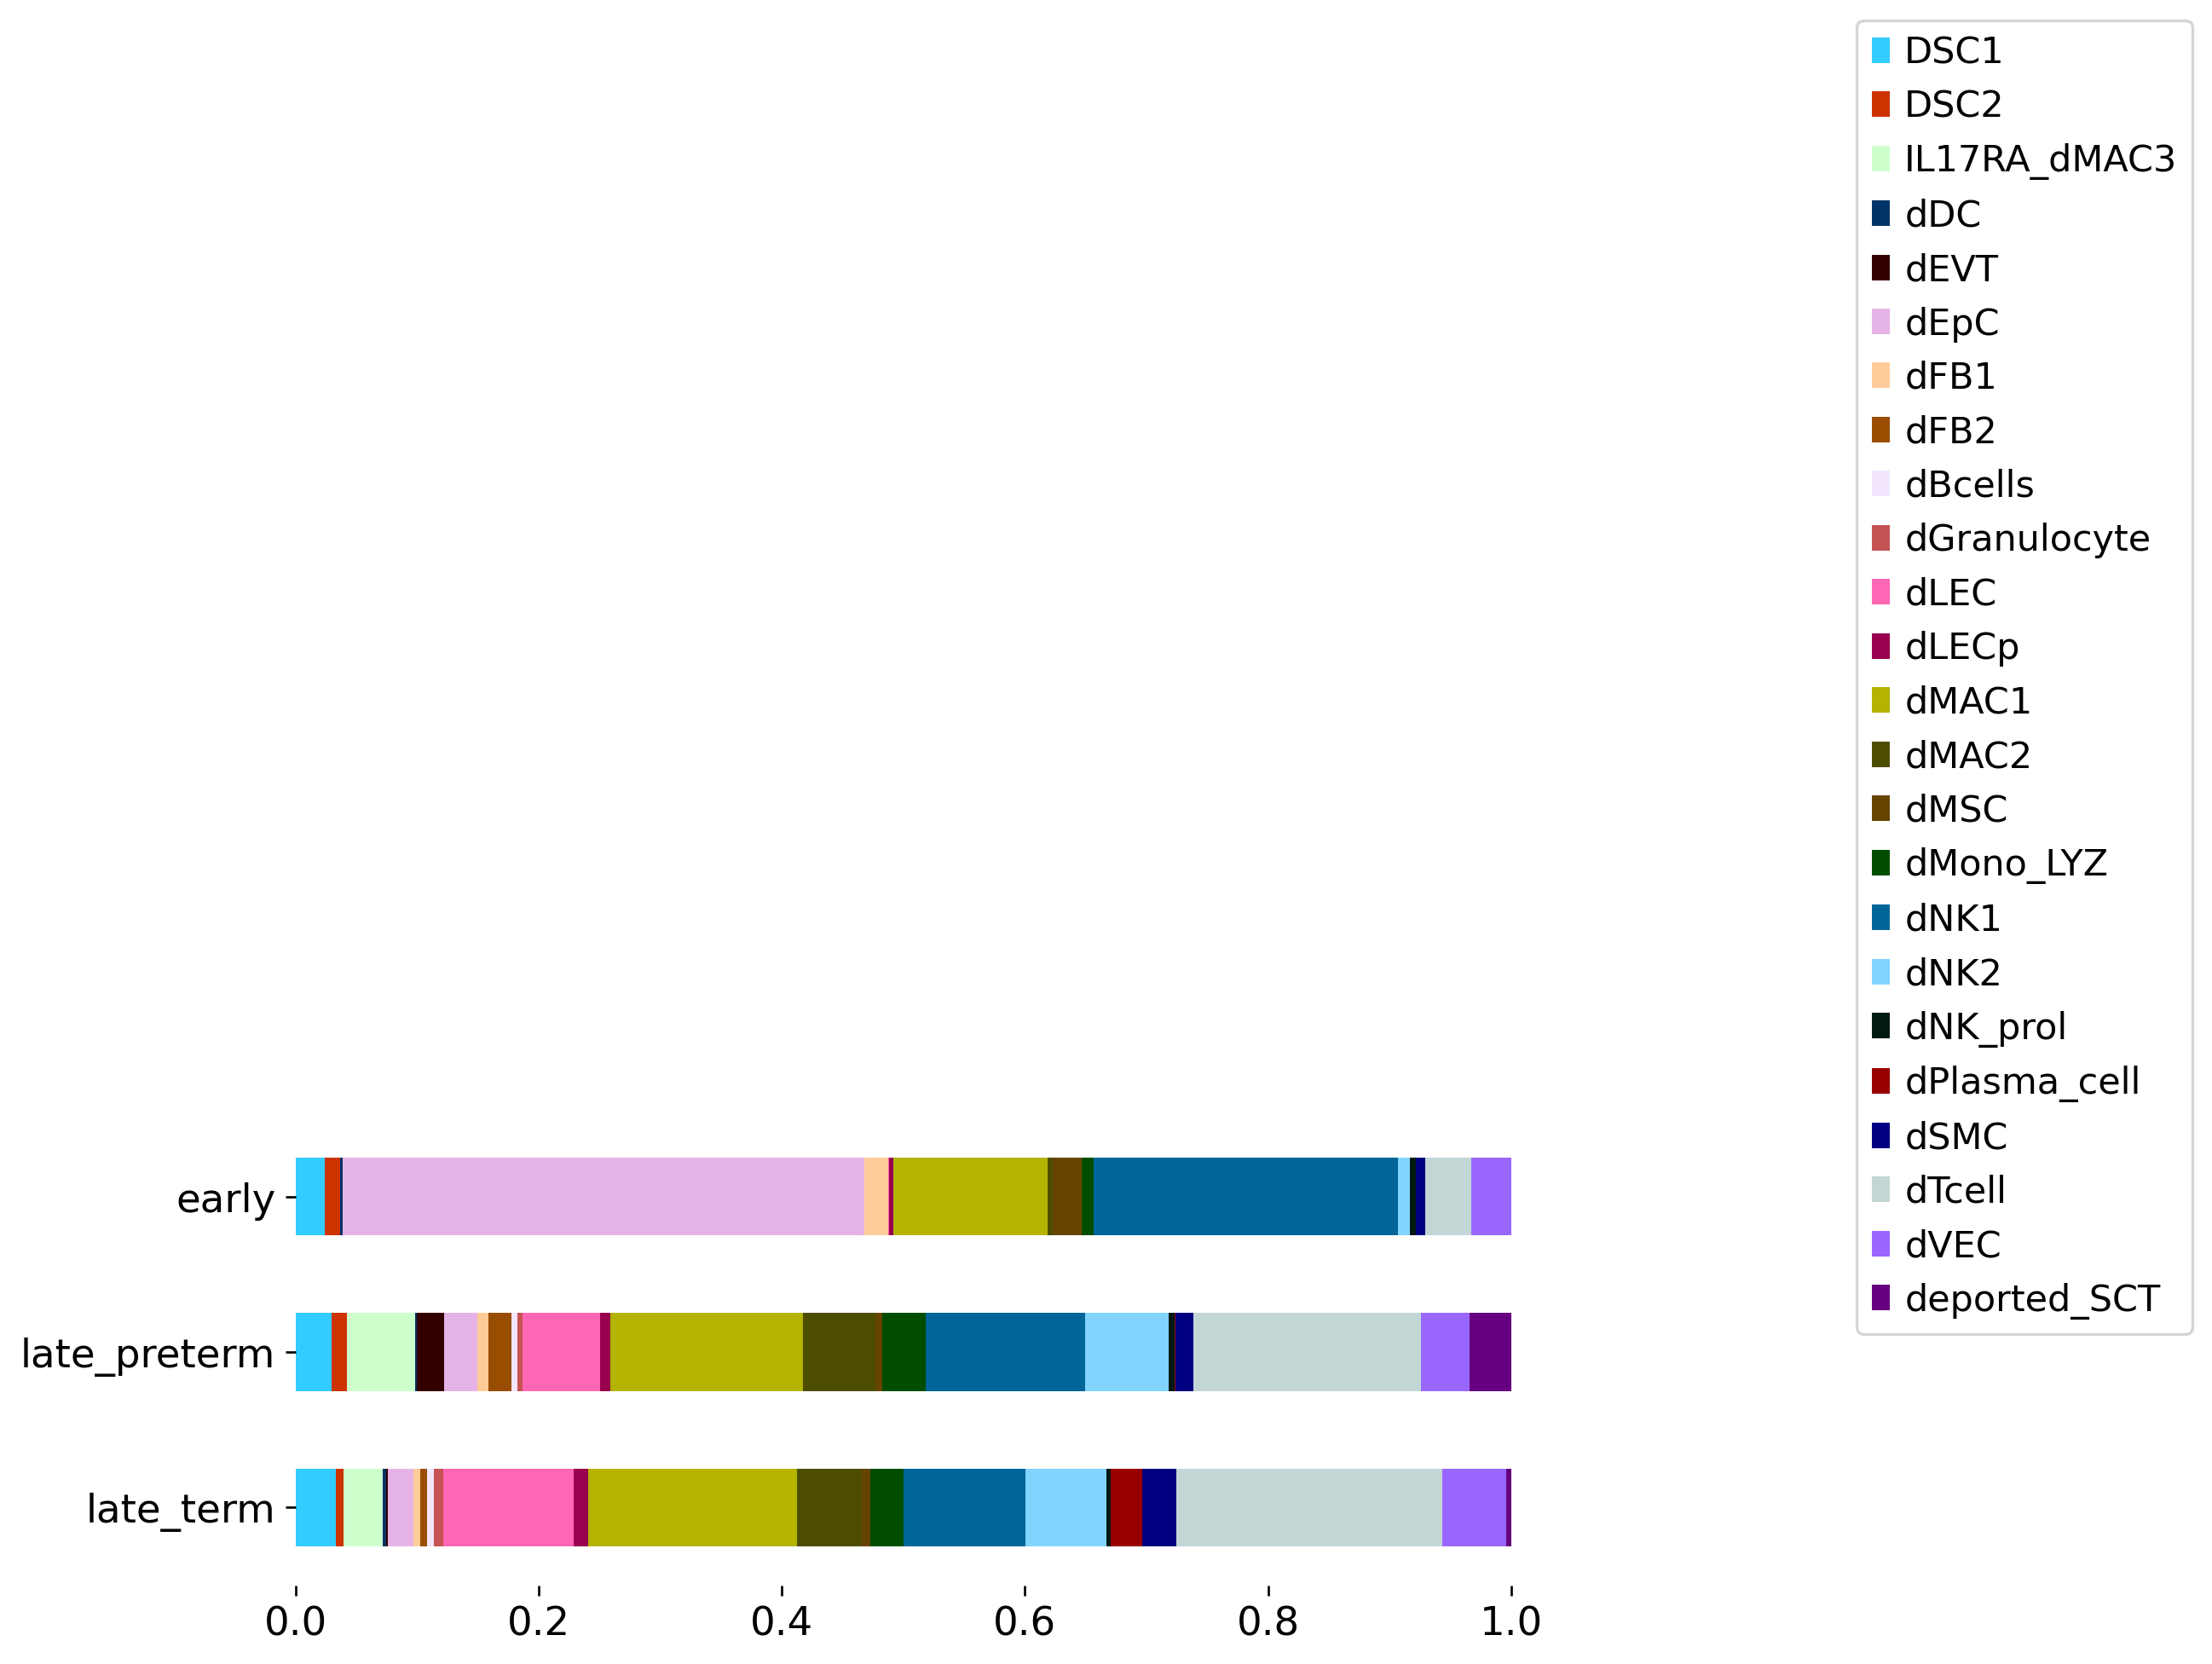

In [27]:
sc.settings.set_figure_params(dpi=120, vector_friendly=True, transparent=True)

import seaborn as sns
make_bar_plots(ldata_filter03)

In [28]:
#Re-order the categories: 
ldata_filter03.obs['celltype_v5_reordered']= ldata_filter03.obs['celltype_v5'].cat.reorder_categories(['dMSC', 'DSC1', 'DSC2', 'dFB1', 'dFB2', 'dSMC', 
'dLEC', 'dLECp', 'dVEC', 'dNK1', 'dNK2', 'dNK_prol', 'dTcell', 'dMono_LYZ', 'IL17RA_dMAC3', 'dMAC1', 'dMAC2', 'dDC',
'dBcells', 'dGranulocyte', 'dPlasma_cell', 'dEpC', 'deported_SCT','dEVT'])

ldata_filter03.obs['celltype_v5_reordered'].cat.categories #reordered

Index(['dMSC', 'DSC1', 'DSC2', 'dFB1', 'dFB2', 'dSMC', 'dLEC', 'dLECp', 'dVEC',
       'dNK1', 'dNK2', 'dNK_prol', 'dTcell', 'dMono_LYZ', 'IL17RA_dMAC3',
       'dMAC1', 'dMAC2', 'dDC', 'dBcells', 'dGranulocyte', 'dPlasma_cell',
       'dEpC', 'deported_SCT', 'dEVT'],
      dtype='object')

In [29]:
#Assign final colors: 
ldata_filter03.uns['celltype_v5_reordered_colors']= ['#004d00', '#33ccff', '#cc3300', '#ffcc99', '#994d00', '#000080','#ff66b3',
'#99004d', '#9966ff', '#006699','#80d4ff', '#001a13', '#c2d6d6', '#004d00', '#ccffcc', '#b3b300', '#4d4d00', 
'#003366', '#f2e6ff', '#c65353', '#990000', '#e6b3e6', '#660080', '#330000']

In [31]:
#Composition analysis: decidua 
#Barplots for each patient:
#Split sample composition by "gestation":
def make_bar_plots(adata, anno_groupby = 'time',
                         anno_subsets = 'celltype_v5_reordered',
                         anno_pointdef = 'time',
                         save_file = 'SP14_SP136_decidua_gestation_composition_110422.pdf'):
    
    ## Get number of categories
    labels = adata.obs[anno_groupby].cat.categories.tolist()
    n_labels = len(labels)
    subset_ids = adata.obs[anno_subsets].cat.categories.tolist()
    n_subsets = len(subset_ids)
    patient_ids = adata.obs[anno_pointdef].cat.categories.tolist()
    n_patients = len(patient_ids)

    ## Calculate subset fractions
    subset_frac = pd.DataFrame(np.empty([n_patients, n_subsets]),
                                    index = patient_ids ,
                                    columns = subset_ids)
    for i in np.arange(n_patients):
        ind2 = adata.obs[anno_pointdef] == patient_ids[i]
        for j in np.arange(n_subsets):
            ind1 = adata.obs[anno_subsets] == subset_ids[j]
            subset_frac.iloc[i,j] = sum(ind1&ind2)
    subset_frac = subset_frac.apply(lambda x: x/sum(x),axis=1)

    ## Get patient labels
    patient_phenos = pd.DataFrame(index = subset_frac.index, columns=[anno_groupby])
    for i in range(0,len(labels)):
        p_list = adata.obs[anno_pointdef][adata.obs[anno_groupby] == labels[i]].unique().tolist()
        patient_phenos[anno_groupby][p_list] = labels[i]
    patient_phenos['time'] = patient_phenos['time'].astype('category')
    patient_phenos['time'] = patient_phenos['time'].cat.reorder_categories(labels)
    ord_ind = patient_phenos.sort_values('time', ascending=False).index

    subset_frac = subset_frac.loc[ord_ind]

    fig, axes = plt.subplots(1,1, figsize=(10,3))

    subset_frac.plot.barh(stacked=True, grid=False, legend=False, ax=axes, color= ['#004d00', '#33ccff', '#cc3300', '#ffcc99', '#994d00', '#000080','#ff66b3',
'#99004d', '#9966ff', '#006699','#80d4ff', '#001a13', '#c2d6d6', '#004d00', '#ccffcc', '#b3b300', '#4d4d00', 
'#003366', '#f2e6ff', '#c65353', '#990000', '#e6b3e6', '#660080', '#330000'])

    box = axes.get_position()
    axes.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    axes.legend(loc='lower right', bbox_to_anchor=(1.5, 0.5), frameon=True)
    sns.despine(left=True, bottom=True, right=True)
    plt.tight_layout()
    plt.savefig(save_file)

/home/debnatho/anaconda3/envs/scvi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


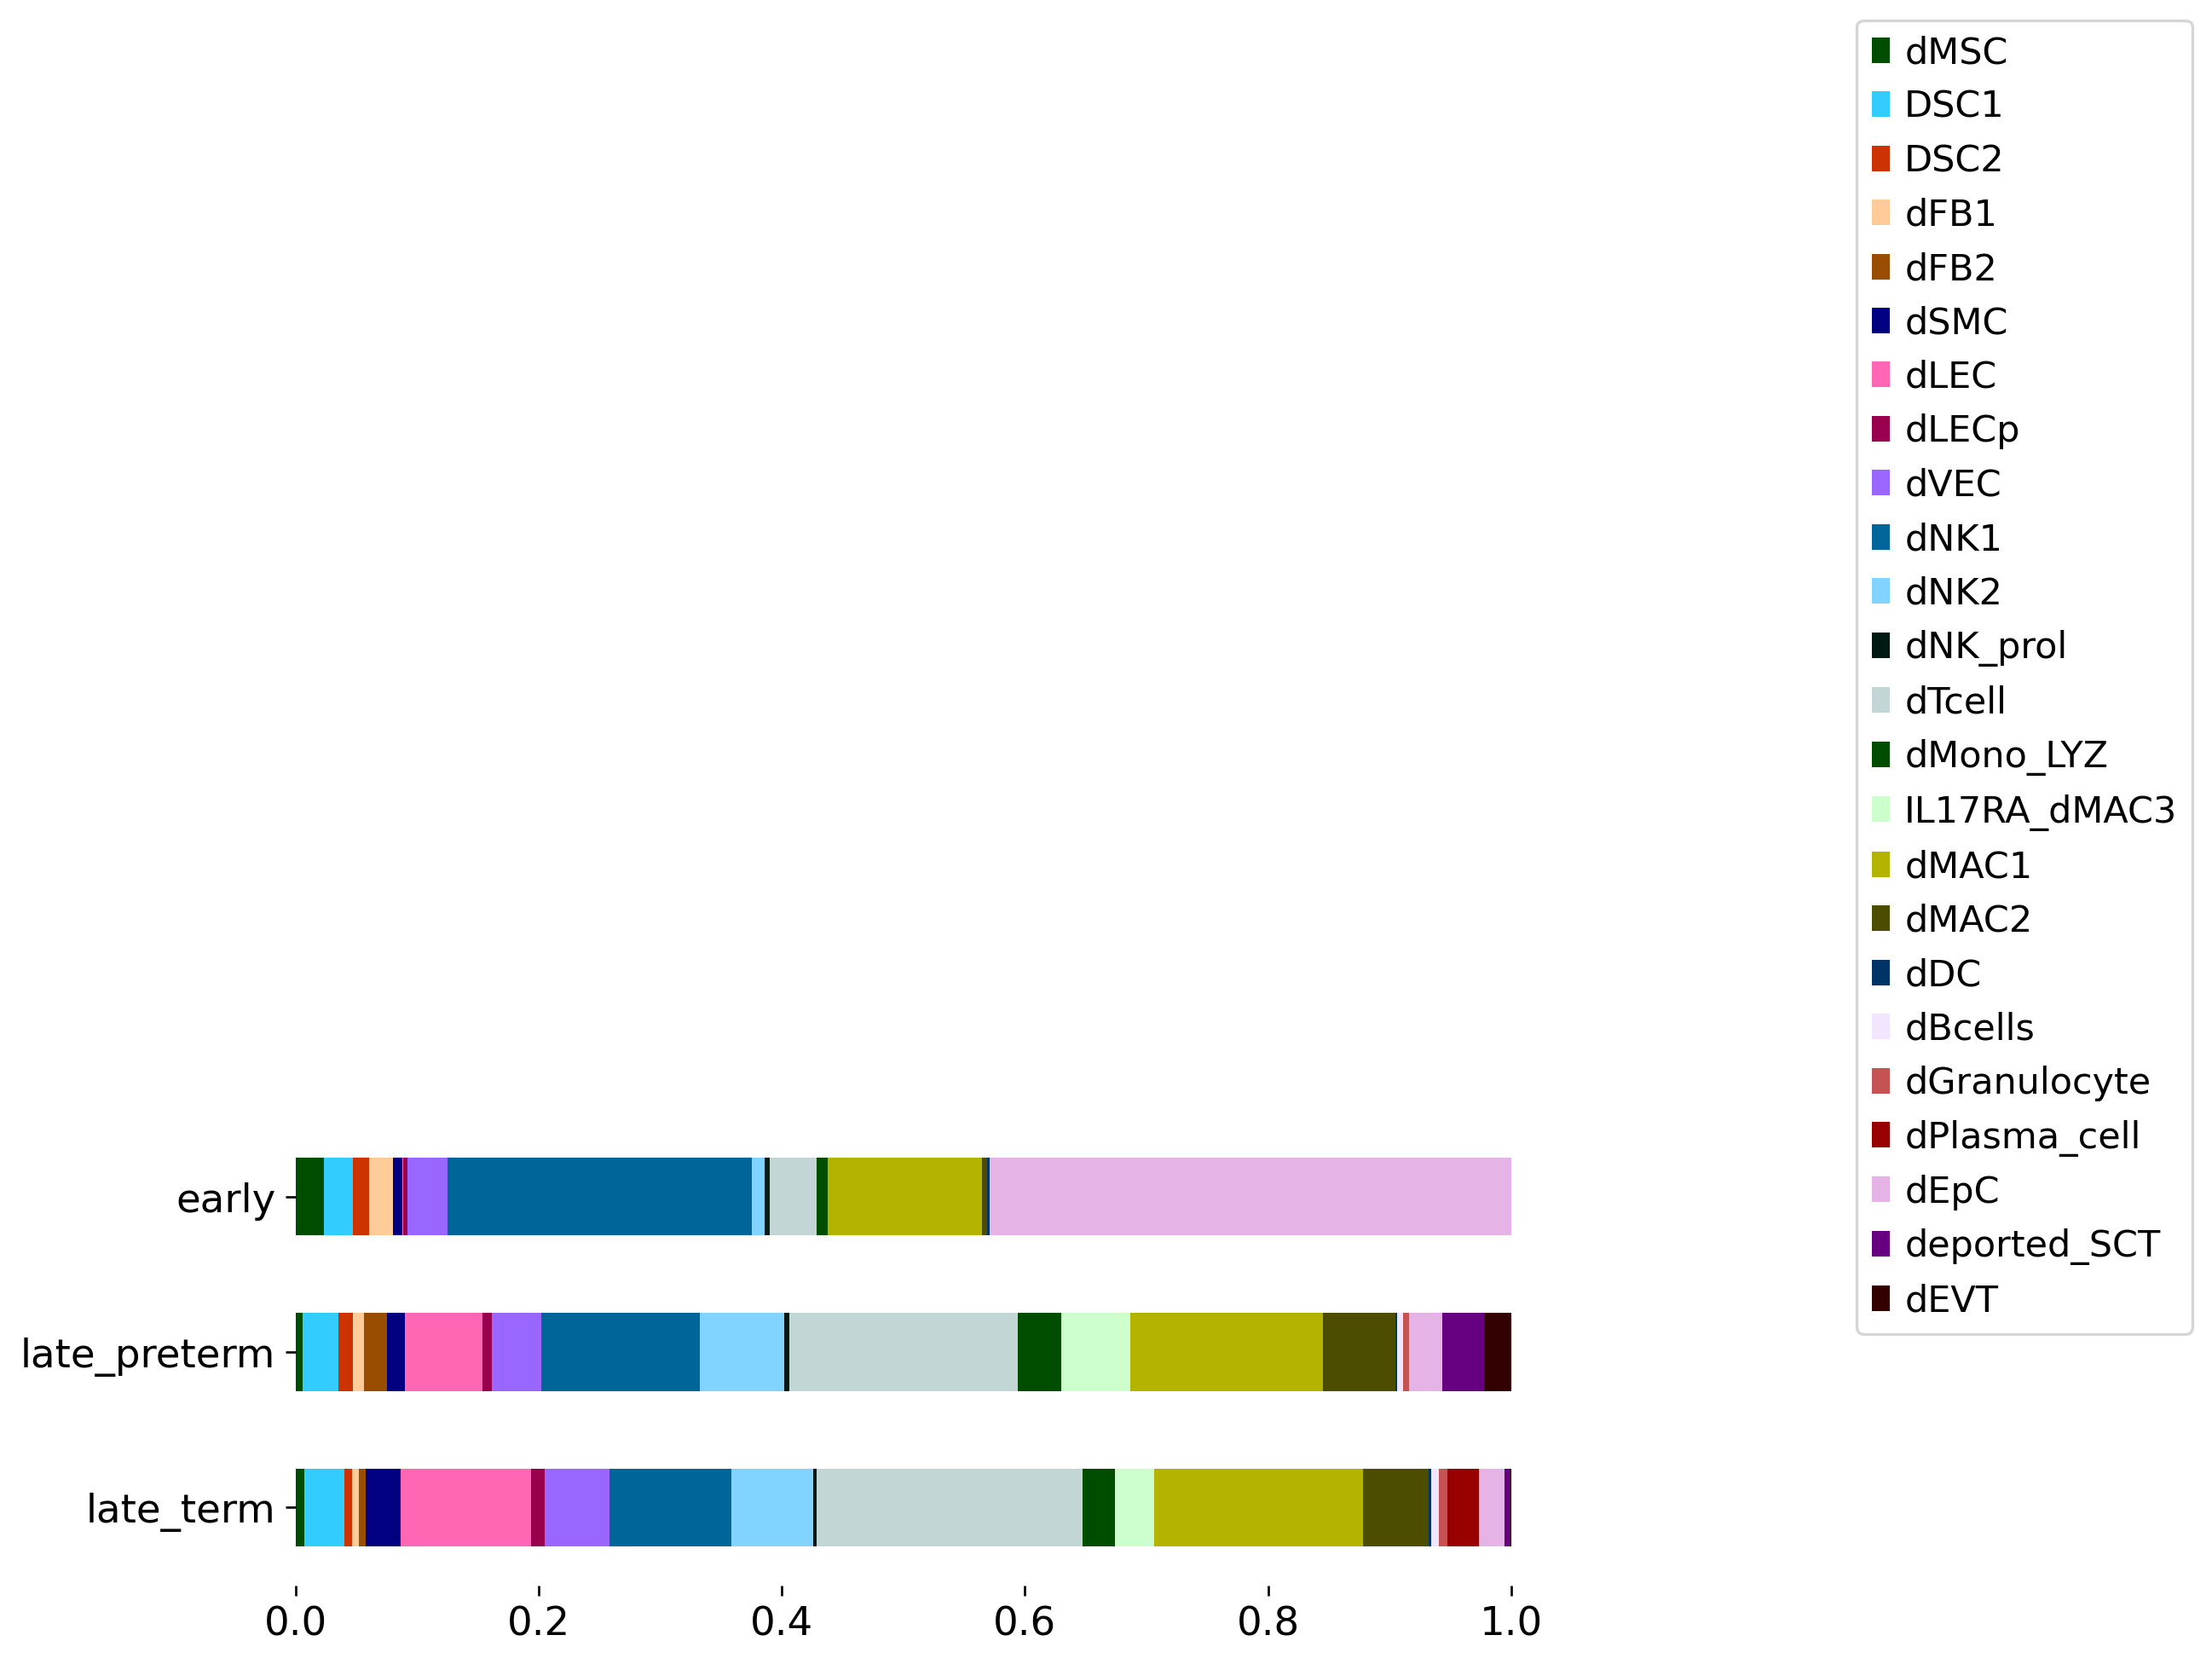

In [32]:
#Run the above function after fixing the correct color orders (in subset_frac.plot.barh)

make_bar_plots(ldata_filter03, anno_subsets = 'celltype_v5_reordered')

In [33]:
#Reorder the donor_id(s): 
ldata_filter03.obs['donor_id_reordered'] = (ldata_filter03.obs["donor_id"].map(lambda x: {"Donor-17025-decidua": "17-025-d", "Donor-SEKR2-decidua": "17-022-d",
"Donor-SOZE1-decidua": "17-021-d", "Donor-327-decidua": "327-d", "Donor-328-decidua": "328-d", 
"Donor-372-decidua": "372-d", "Donor13_SP136": "073-d", "Donor14_SP136": "100-d", 
"Donor15_SP136": "102-d", "Donor-274-decidua": "274-d", "Donor-389-decidua": "389-d", 
"Donor-419-decidua": "419-d"}.get(x, x)).astype("category"))

In [34]:
#Reorder the renamed categories:
ldata_filter03.obs['donor_id_reordered']= ldata_filter03.obs['donor_id_reordered'].cat.reorder_categories(["17-025-d", "17-022-d", 
"17-021-d", "327-d", "328-d", "372-d", "073-d", "100-d", "102-d", "274-d", "389-d", "419-d"])

ldata_filter03.obs['donor_id_reordered'].cat.categories

Index(['17-025-d', '17-022-d', '17-021-d', '327-d', '328-d', '372-d', '073-d',
       '100-d', '102-d', '274-d', '389-d', '419-d'],
      dtype='object')

In [36]:
#make_bar_plots(ldata_filter03, anno_pointdef = 'donor_id_reordered') #composition per sample. 

In [37]:
#Composition analysis: decidua 
#Barplots for each patient & split sample composition by donor_id:

def make_bar_plots(adata, anno_groupby = 'time',
                         anno_subsets = 'celltype_v5_reordered',
                         anno_pointdef = 'donor_id_reordered',
                         save_file = 'Decidua_donorID_composition_v2_110422.pdf'):
    
    ## Get number of categories
    labels = adata.obs[anno_groupby].cat.categories.tolist()
    n_labels = len(labels)
    subset_ids = adata.obs[anno_subsets].cat.categories.tolist()
    n_subsets = len(subset_ids)
    patient_ids = adata.obs[anno_pointdef].cat.categories.tolist()
    n_patients = len(patient_ids)

    ## Calculate subset fractions
    subset_frac = pd.DataFrame(np.empty([n_patients, n_subsets]),
                                    index = patient_ids ,
                                    columns = subset_ids)
    for i in np.arange(n_patients):
        ind2 = adata.obs[anno_pointdef] == patient_ids[i]
        for j in np.arange(n_subsets):
            ind1 = adata.obs[anno_subsets] == subset_ids[j]
            subset_frac.iloc[i,j] = sum(ind1&ind2)
    subset_frac = subset_frac.apply(lambda x: x/sum(x),axis=1)

    ## Get patient labels
    patient_phenos = pd.DataFrame(index = subset_frac.index, columns=[anno_groupby])
    for i in range(0,len(labels)):
        p_list = adata.obs[anno_pointdef][adata.obs[anno_groupby] == labels[i]].unique().tolist()
        patient_phenos[anno_groupby][p_list] = labels[i]
    patient_phenos['time'] = patient_phenos['time'].astype('category')
    patient_phenos['time'] = patient_phenos['time'].cat.reorder_categories(labels)
    ord_ind = patient_phenos.sort_values('time', ascending=False).index

    subset_frac = subset_frac.loc[ord_ind]

    fig, axes = plt.subplots(1,1, figsize=(9,10))

    subset_frac.plot.barh(stacked=True, grid=False, legend=False, ax=axes, color= ['#004d00', '#33ccff', '#cc3300', '#ffcc99', '#994d00', '#000080','#ff66b3',
'#99004d', '#9966ff', '#006699','#80d4ff', '#001a13', '#c2d6d6', '#004d00', '#ccffcc', '#b3b300', '#4d4d00', 
'#003366', '#f2e6ff', '#c65353', '#990000', '#e6b3e6', '#660080', '#330000'])

    box = axes.get_position()
    axes.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    axes.legend(loc='lower right', bbox_to_anchor=(1.5, 0.5), frameon=True)
    sns.despine(left=True, bottom=True, right=True)
    plt.tight_layout()
    plt.savefig(save_file)

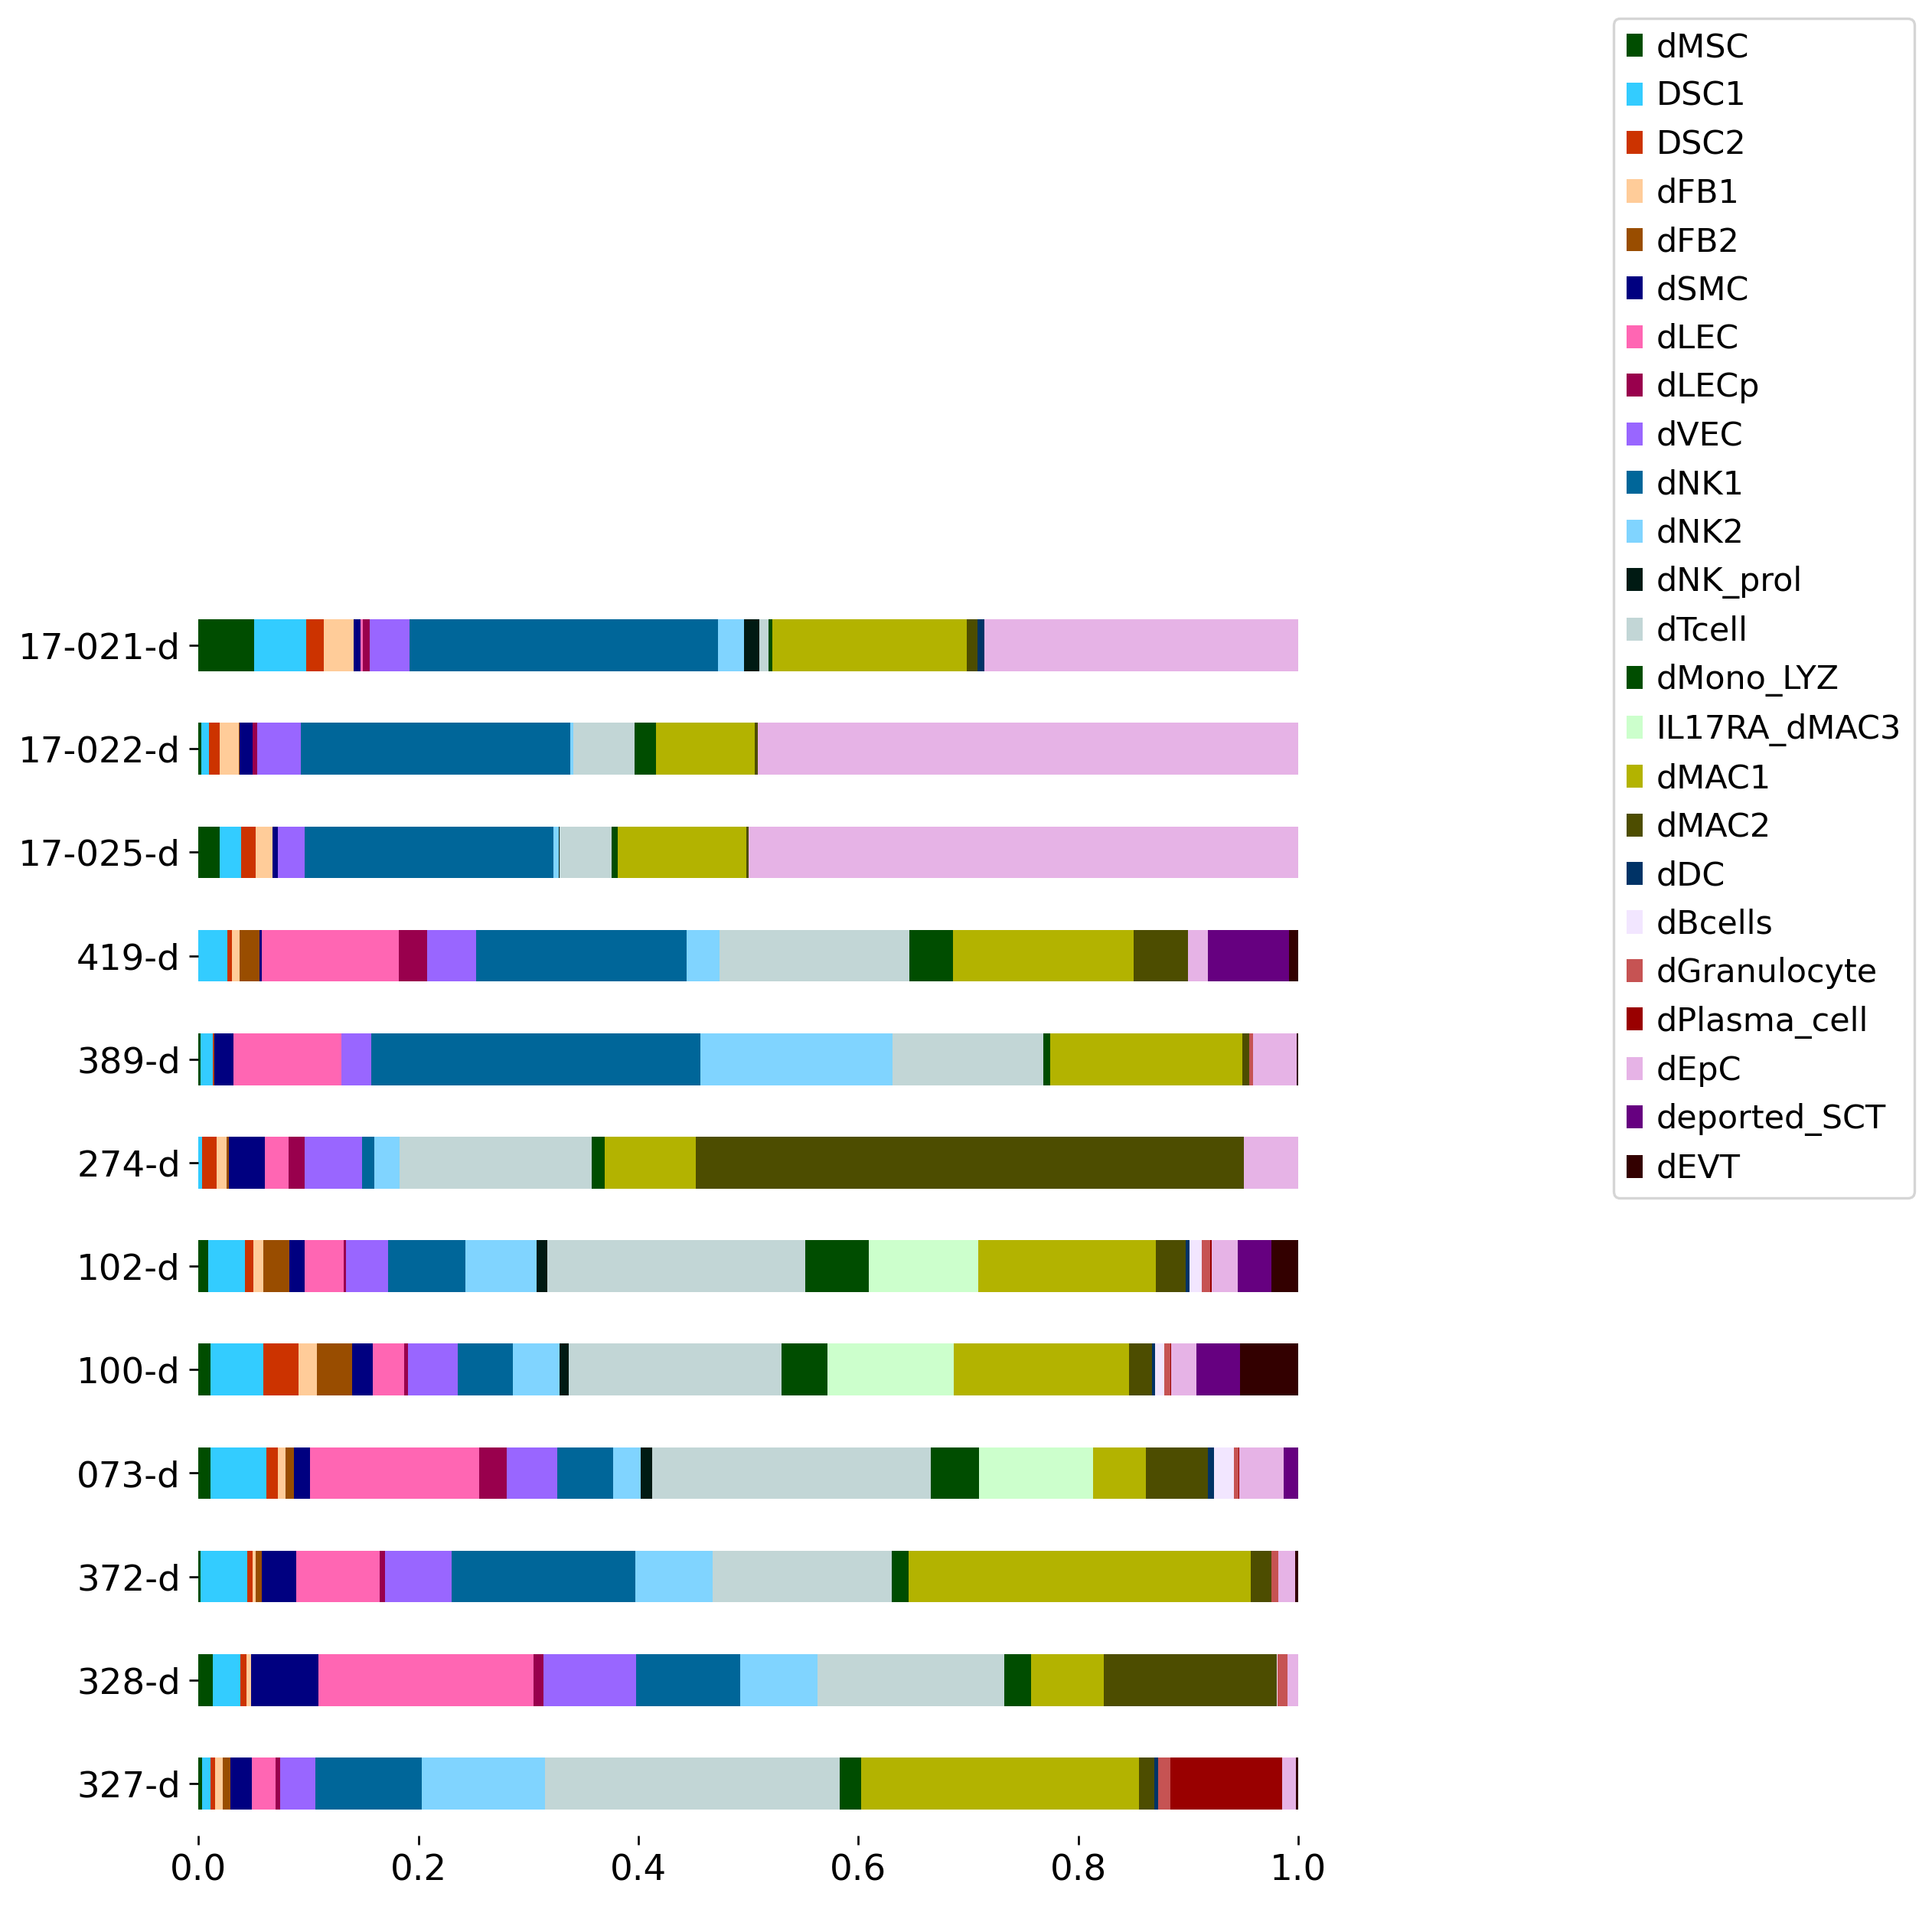

In [38]:
#Extended figure 1E. However, the figure was redone on GraphPad after minor amendments (such as, reordering the cell types)
make_bar_plots(ldata_filter03, anno_pointdef = 'donor_id_reordered') #composition per sample. 

In [39]:
#Rename the clusters a/c to current manuscript annotations: 
ldata_filter03.obs['celltype_annotations']= ldata_filter03.obs['celltype_v5'].map(lambda x: {"IL17RA_dMAC3": "dMono2",
"dMono_LYZ": "dMono1", "deported_SCT": "dDSTB", "dNK_prol": "dNKp", "dPlasma_cell": "dPlasmaC", "dGranulocyte": "dGranul",
"dGranul_new": "dBcell"}.get(x, x)).astype("category")

ldata_filter03.obs['celltype_annotations'].cat.categories

Index(['DSC1', 'DSC2', 'dMono2', 'dDC', 'dEVT', 'dEpC', 'dFB1', 'dFB2',
       'dBcells', 'dGranul', 'dLEC', 'dLECp', 'dMAC1', 'dMAC2', 'dMSC',
       'dMono1', 'dNK1', 'dNK2', 'dNKp', 'dPlasmaC', 'dSMC', 'dTcell', 'dVEC',
       'dDSTB'],
      dtype='object')

In [41]:
ldata_filter03.uns['celltype_annotations_colors']= ['#33ccff', '#cc3300', '#ccffcc','#003366', 
    '#330000','#e6b3e6', '#ffcc99', '#994d00', '#f2e6ff', '#c65353', '#ff66b3', '#99004d',
    '#b3b300', '#4d4d00', '#664400', '#004d00', '#006699', '#80d4ff', '#001a13', '#990000', 
    '#000080', '#c2d6d6', '#9966ff', '#660080']

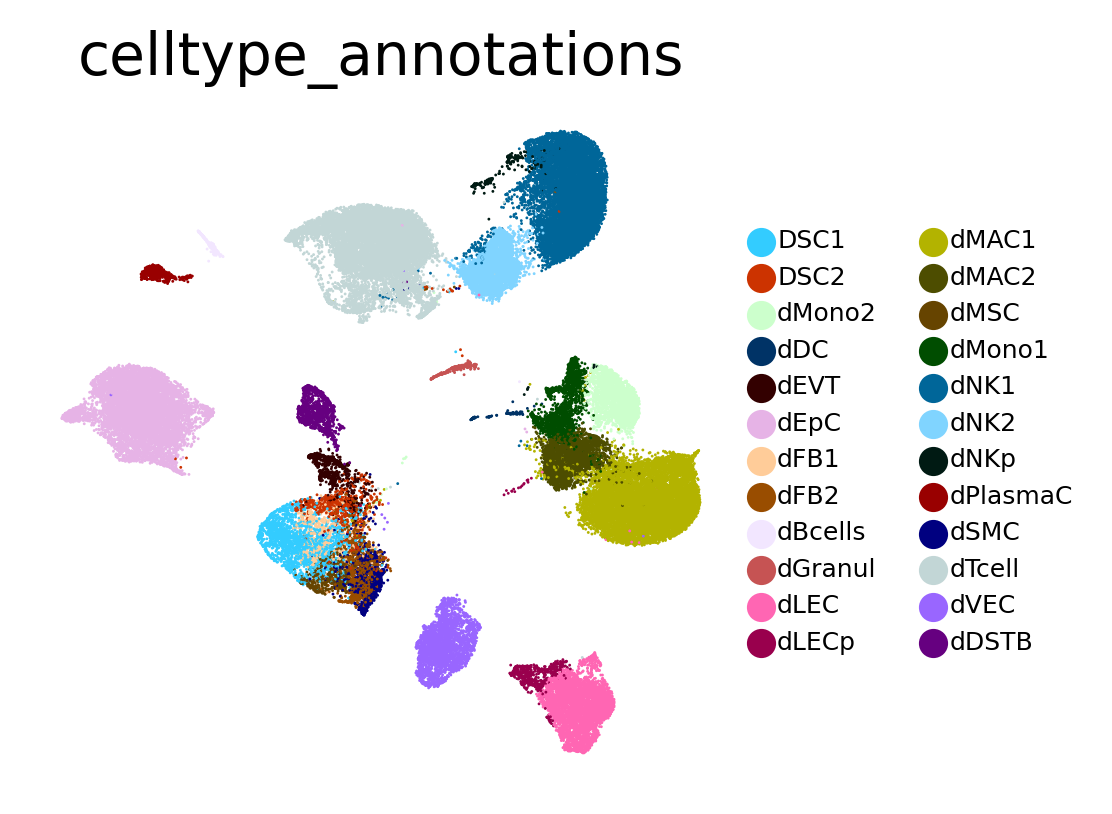

In [42]:
sc.settings.set_figure_params(dpi=150, dpi_save=200, vector_friendly=True, transparent=True)
plt.rcParams["figure.figsize"] = (3,3)

#Generate figures for the manuscript: Main figure-1B. 
sc.pl.umap(ldata_filter03, color= ['celltype_annotations'], legend_fontoutline=0, 
           frameon=False, legend_fontsize=6) #save= 'decidua_atlas_110422.pdf' 

10X v2
10X v3


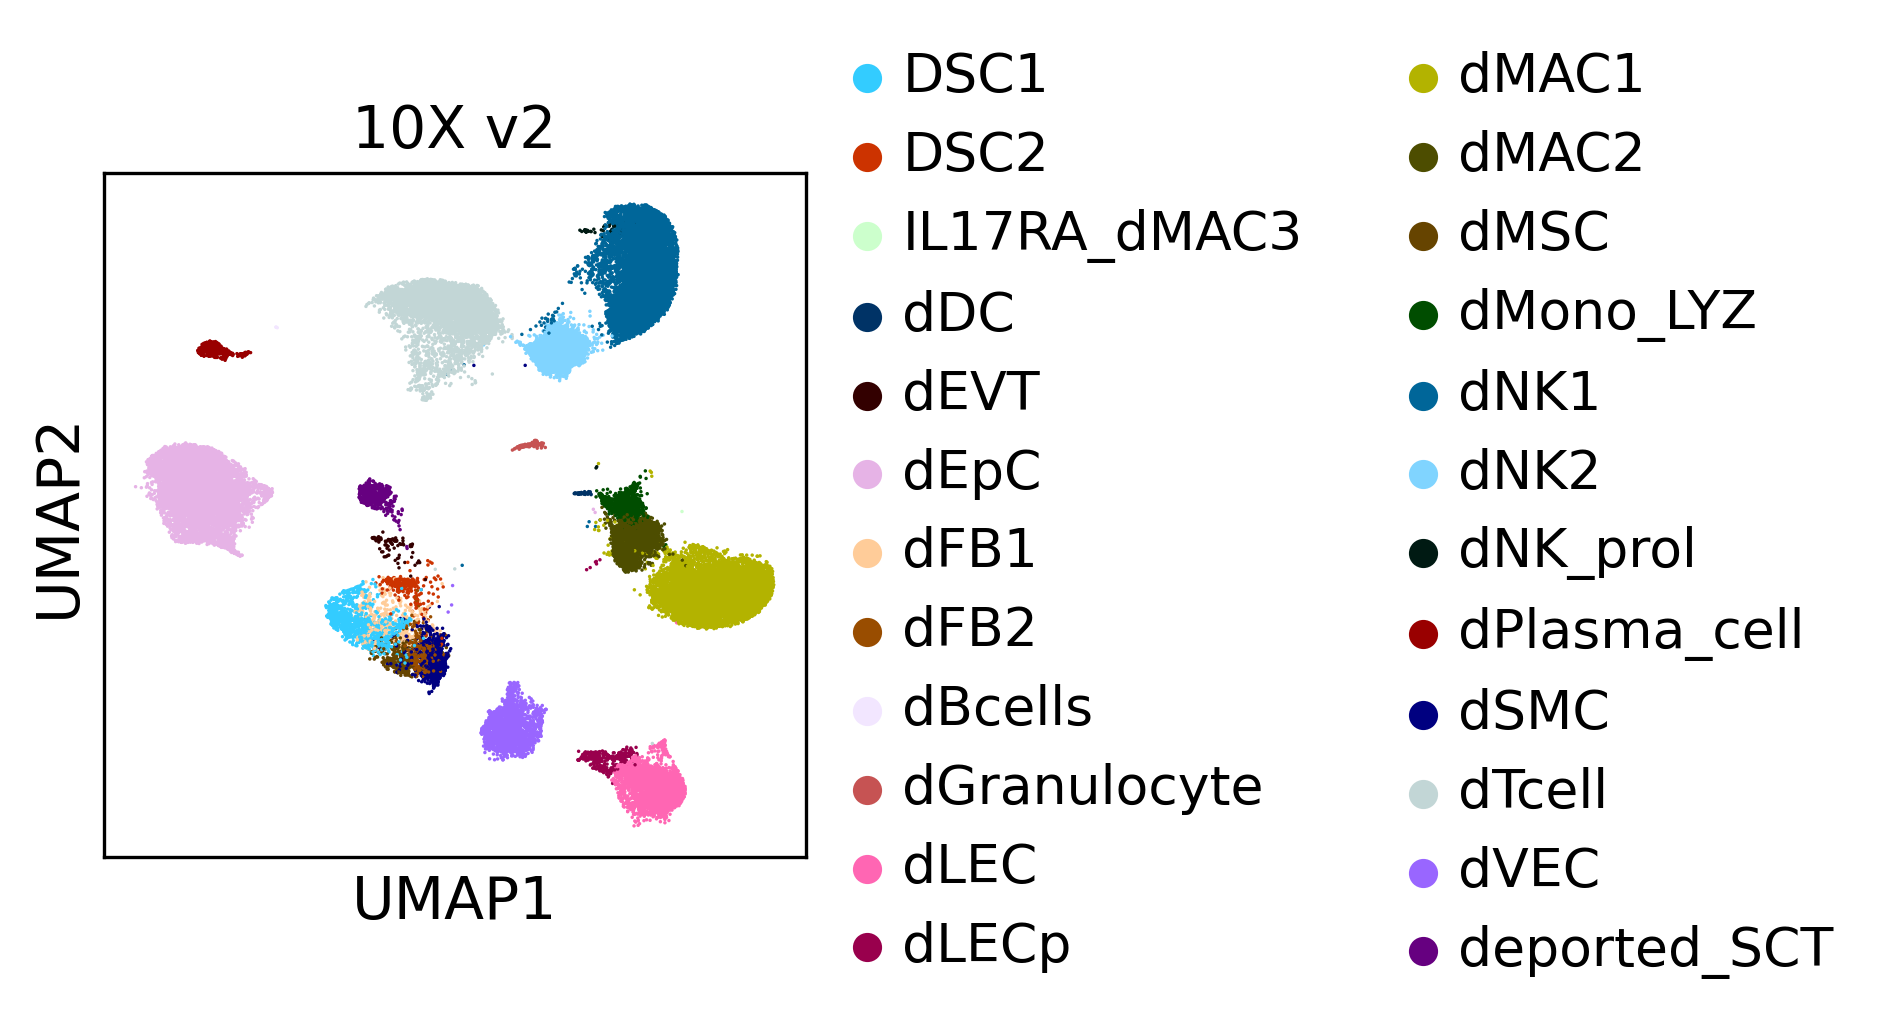

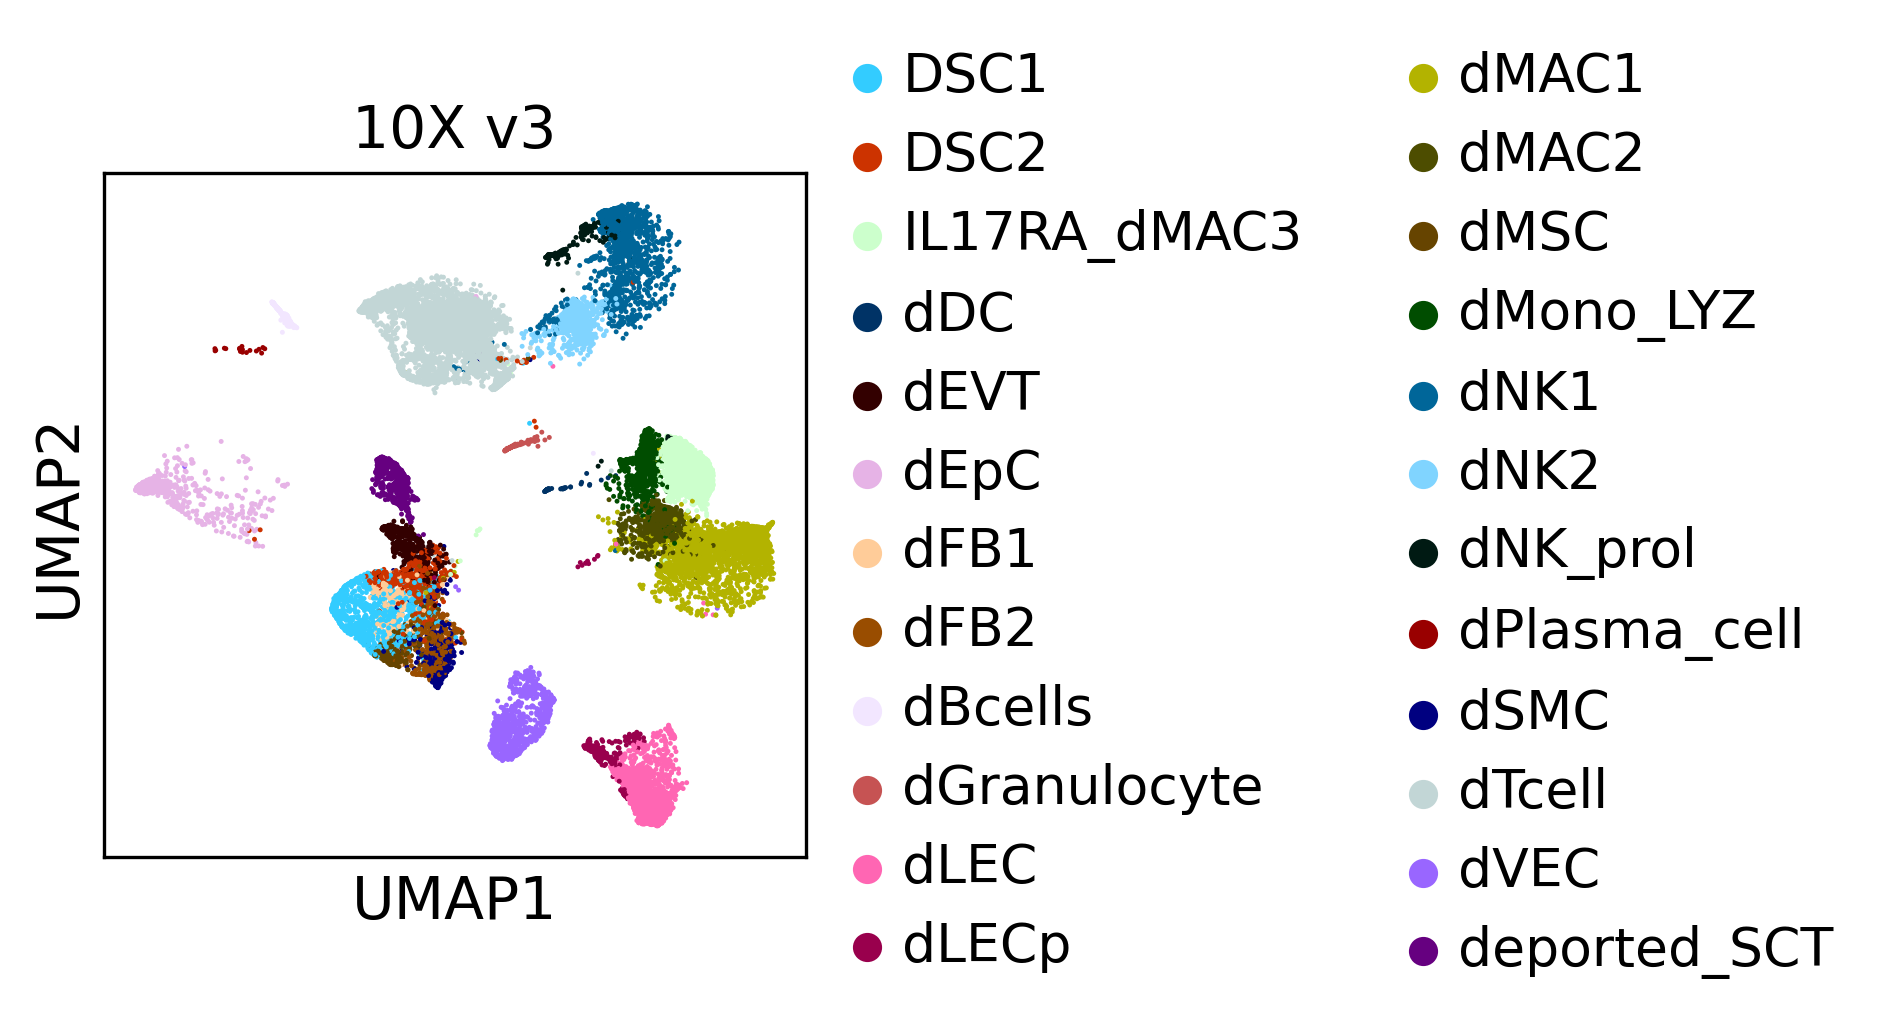

In [43]:
##Split by gestational time: 
#pdf = matplotlib.backends.backend_pdf.PdfPages("Decidua_umap_library_110422.pdf")

for i in ldata_filter03.obs['library'].cat.categories:
    print(i) 
    fig= sc.pl.umap(ldata_filter03[ldata_filter03.obs['library'] == i], color = 'celltype_v5', return_fig=True, title= i)
    #pdf.savefig(fig)
    
#pdf.close() 

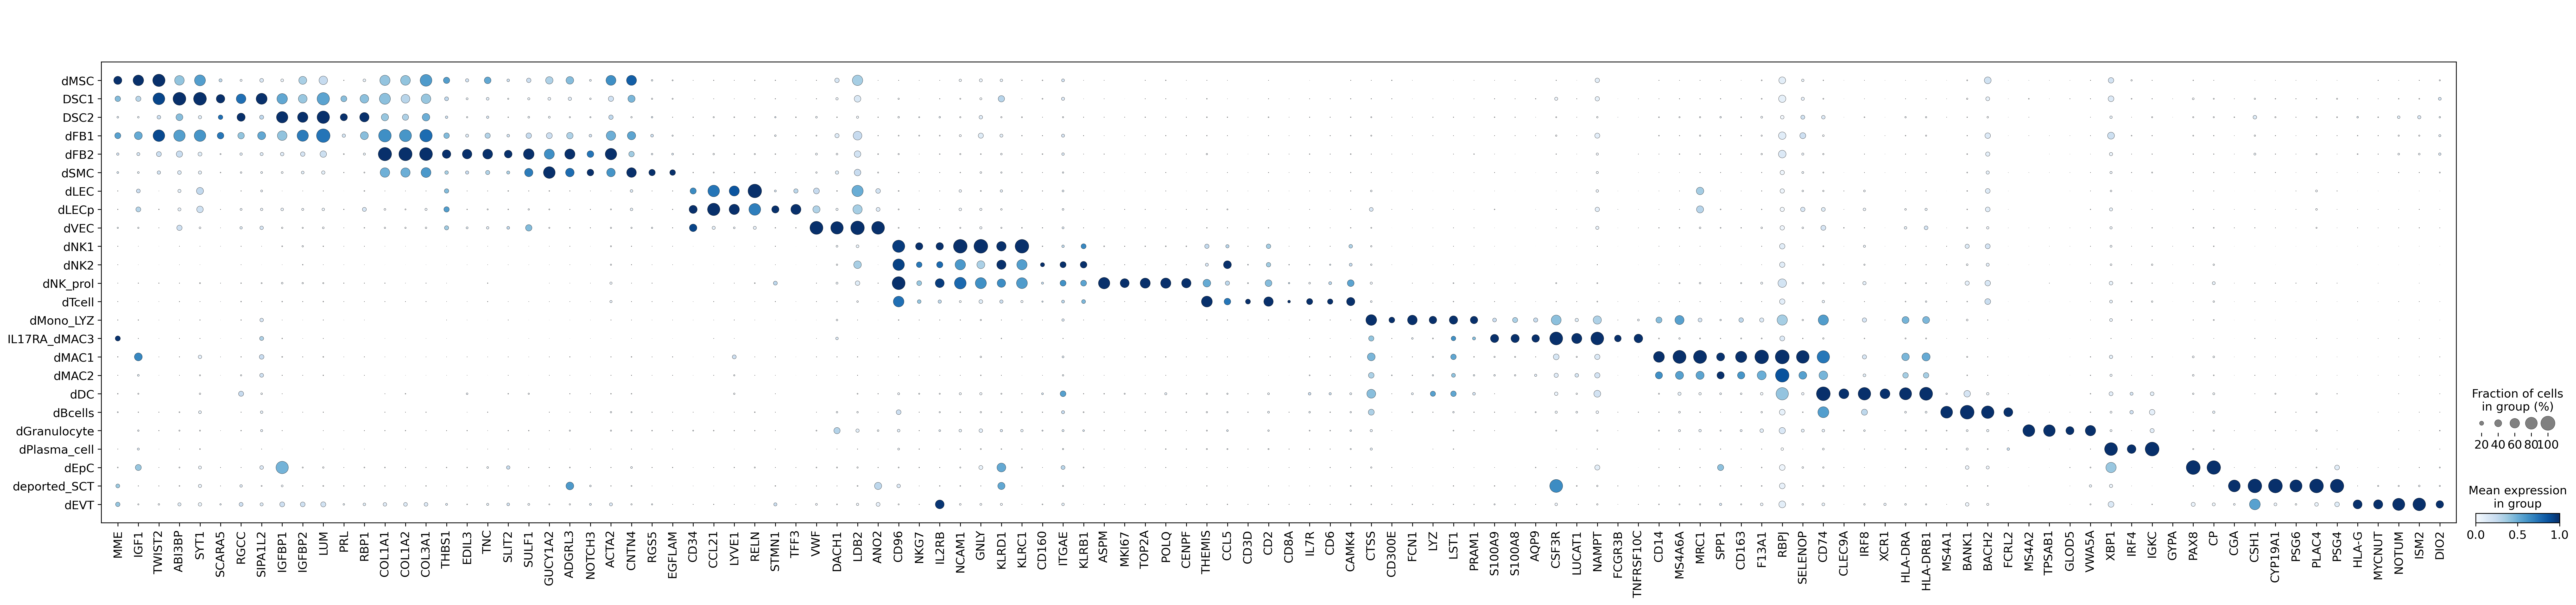

In [44]:
#Dot-plot depicting well known decidua cell types/states:
#The marker dict below is extracted from computational analysis as well as literature. 
#Features are scaled across clusters. 
recommended_genes= ['MME', 'IGF1', 'TWIST2', 'ABI3BP', 'SYT1', 'SCARA5','RGCC', 'SIPA1L2', 
'IGFBP1', 'IGFBP2','LUM', 'PRL', 'RBP1', 'COL1A1', 'COL1A2', 'COL3A1', 
'THBS1', 'EDIL3', 'TNC', 'SLIT2', 'SULF1', 'GUCY1A2', 'ADGRL3', 'NOTCH3', 'ACTA2', 'CNTN4', 'RGS5','EGFLAM',
'CD34', 'CCL21', 'LYVE1', 'RELN', 'STMN1', 'TFF3', 'VWF', 'DACH1', 'LDB2', 'ANO2', 
'CD96', 'NKG7', 'IL2RB', 'NCAM1', 'GNLY', 'KLRD1', 'KLRC1', 'CD160', 'ITGAE', 'KLRB1',  
'ASPM', 'MKI67', 'TOP2A', 'POLQ', 'CENPF', 
'THEMIS', 'CCL5', 'CD3D', 'CD2', 'CD8A', 'IL7R', 'CD6',  
'CAMK4', 'CTSS', 'CD300E', 'FCN1', 'LYZ', 'LST1', 'PRAM1', 
'S100A9', 'S100A8', 'AQP9', 'CSF3R', 'LUCAT1', 'NAMPT', 'FCGR3B', 'TNFRSF10C', 'CD14', 
'MS4A6A', 'MRC1', 'SPP1', 'CD163', 'F13A1', 'RBPJ', 'SELENOP', 
'CD74', 'CLEC9A', 'IRF8', 'XCR1', 'HLA-DRA', 'HLA-DRB1', 'MS4A1', 'BANK1', 'BACH2', 'FCRL2', 'MS4A2', 'TPSAB1', 'GLOD5', 'VWA5A', 
'XBP1', 'IRF4', 'IGKC', 
'GYPA', 'PAX8', 'CP', 'CGA', 'CSH1', 'CYP19A1', 'PSG6', 'PLAC4', 'PSG4', 'HLA-G', 'MYCNUT', 'NOTUM', 'ISM2', 'DIO2']


#Extended figure 2B: 
sc.pl.dotplot(ldata_filter03, recommended_genes, groupby= 'celltype_v5_reordered', dendrogram=False, 
              color_map="Blues", use_raw=True, standard_scale="var") #save= '_decidua_cell_markers_110422.pdf' 

In [45]:
#Tabulate composition for supplementary tables:
pd.crosstab(ldata_filter03.obs['celltype_v5'], ldata_filter03.obs['time']).to_csv('./decidua_composition_2022/Per_gestation_noNKT_11042022.csv')
pd.crosstab(ldata_filter03.obs['celltype_v5'], ldata_filter03.obs['disease']).to_csv('./decidua_composition_2022/Per_condition_noNKT_11042022.csv')
ldata_filter03.obs['celltype_v5'].value_counts().to_csv('./decidua_composition_2022/Celltype_composition_all_noNKT_11042022.csv')

Evaluation of scVI integration (batch effect correction):

1). Rand index adjusted for chance (ARI): The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. ARI hence has a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation).

2). Adjusted Mutual Information between two clusterings: adjustment of the Mutual Information (MI) score to account for chance. It accounts for the fact that the MI is generally higher for two clusterings with a larger number of clusters, regardless of whether there is actually more information shared. This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

In [46]:
from sklearn.metrics.cluster import adjusted_rand_score

adjusted_rand_score(ldata_filter03.obs['celltype_v5'], ldata_filter03.obs['donor_id'])

0.06329506731142476

In [48]:
print(adjusted_rand_score(ldata_filter03.obs['celltype_v5'], ldata_filter03.obs['library']))
print(adjusted_rand_score(ldata_filter03.obs['celltype_v5'], ldata_filter03.obs['procurement'])) 
print(adjusted_rand_score(ldata_filter03.obs['celltype_v5'], ldata_filter03.obs['gestational_weeks'])) 

0.035593100743844426
0.03470117649647962
0.073678375345648


In [49]:
from sklearn.metrics.cluster import adjusted_mutual_info_score

adjusted_mutual_info_score(ldata_filter03.obs['celltype_v5'], ldata_filter03.obs['donor_id'])

0.16055687004452382

An absolute silhouette score (ASW) of batch labels per cell-type were computed to measure batch-mixing (scaled from 0 to 1 where 1 indicates ideal batch mixing and 0 represents strongly separated batches). Since the batches are expected to integrate within a cell identity, the batch ASW was computed per cell type/state. The mean scores for placenta (0.863) and decidua (0.802) cell type/states indicate well batch-mixing alongside bio-conservation. This analysis was performed based on Luecken et. al Nature Methods 2021.

In [50]:
#Cell type ASW computation:
#Function grabbed from https://www.nature.com/articles/s41592-021-01336-8#code-availability 

from sklearn.metrics.cluster import silhouette_samples, silhouette_score

def silhouette(
        adata,
        group_key,
        embed,
        metric='euclidean',
        scale=True
):
    """
    Wrapper for sklearn silhouette function values range from [-1, 1] with
        1 being an ideal fit
        0 indicating overlapping clusters and
        -1 indicating misclassified cells
    By default, the score is scaled between 0 and 1. This is controlled `scale=True`
    :param group_key: key in adata.obs of cell labels
    :param embed: embedding key in adata.obsm, default: 'X_pca'
    :param scale: default True, scale between 0 (worst) and 1 (best)
    """
    if embed not in adata.obsm.keys():
        print(adata.obsm.keys())
        raise KeyError(f'{embed} not in obsm')
    asw = silhouette_score(
        X=adata.obsm[embed],
        labels=adata.obs[group_key],
        metric=metric
    )
    if scale:
        asw = (asw + 1) / 2
    return asw


def silhouette_batch(
        adata,
        batch_key,
        group_key,
        embed,
        metric='euclidean',
        return_all=False,
        scale=True,
        verbose=True
):
    """
    Absolute silhouette score of batch labels subsetted for each group.
    :param batch_key: batches to be compared against
    :param group_key: group labels to be subsetted by e.g. cell type
    :param embed: name of column in adata.obsm
    :param metric: see sklearn silhouette score
    :param scale: if True, scale between 0 and 1
    :param return_all: if True, return all silhouette scores and label means
        default False: return average width silhouette (ASW)
    :param verbose:
    :return:
        average width silhouette ASW
        mean silhouette per group in pd.DataFrame
        Absolute silhouette scores per group label
    """
    if embed not in adata.obsm.keys():
        print(adata.obsm.keys())
        raise KeyError(f'{embed} not in obsm')

    sil_all = pd.DataFrame(columns=['group', 'silhouette_score'])

    for group in adata.obs[group_key].unique():
        adata_group = adata[adata.obs[group_key] == group]
        n_batches = adata_group.obs[batch_key].nunique()

        if (n_batches == 1) or (n_batches == adata_group.shape[0]):
            continue

        sil_per_group = silhouette_samples(
            adata_group.obsm[embed],
            adata_group.obs[batch_key],
            metric=metric
        )

        # take only absolute value
        sil_per_group = [abs(i) for i in sil_per_group]

        if scale:
            # scale s.t. highest number is optimal
            sil_per_group = [1 - i for i in sil_per_group]

        sil_all = sil_all.append(
            pd.DataFrame({
                'group': [group] * len(sil_per_group),
                'silhouette_score': sil_per_group
            })
        )

    sil_all = sil_all.reset_index(drop=True)
    sil_means = sil_all.groupby('group').mean()
    asw = sil_means['silhouette_score'].mean()

    if verbose:
        print(f'mean silhouette per cell: {sil_means}')

    if return_all:
        return asw, sil_means, sil_all

    return asw

In [52]:
emb_key_ = "X_scANVI"

#Cell type ASW silhouette_batch()
silhouette_batch(ldata_filter03, 'donor_id', 'celltype_v5', emb_key_)

mean silhouette per cell:               silhouette_score
group                         
DSC1                  0.741036
DSC2                  0.801799
IL17RA_dMAC3          0.899458
dBcells               0.816481
dDC                   0.724357
dEVT                  0.676473
dEpC                  0.854589
dFB1                  0.761064
dFB2                  0.756063
dGranulocyte          0.795844
dLEC                  0.861333
dLECp                 0.735733
dMAC1                 0.861274
dMAC2                 0.876070
dMSC                  0.820725
dMono_LYZ             0.877161
dNK1                  0.864137
dNK2                  0.913961
dNK_prol              0.773842
dPlasma_cell          0.533861
dSMC                  0.815339
dTcell                0.813945
dVEC                  0.851758
deported_SCT          0.778037


0.8001808415109367

In [53]:
emb_key_ = "X_scANVI"

#Cell type ASW silhouette_batch()
silhouette_batch(ldata_filter03, 'donor_id', 'celltype_annotations', emb_key_)

mean silhouette per cell:           silhouette_score
group                     
DSC1              0.741036
DSC2              0.801799
dBcells           0.816481
dDC               0.724357
dDSTB             0.778037
dEVT              0.676473
dEpC              0.854589
dFB1              0.761064
dFB2              0.756063
dGranul           0.795844
dLEC              0.861333
dLECp             0.735733
dMAC1             0.861274
dMAC2             0.876070
dMSC              0.820725
dMono1            0.877161
dMono2            0.899458
dNK1              0.864137
dNK2              0.913961
dNKp              0.773842
dPlasmaC          0.533861
dSMC              0.815339
dTcell            0.813945
dVEC              0.851758


0.8001808415109367

The silhouette width measures the relationship between the within-cluster distances of a cell and the between-cluster distances of that cell to the closest cluster. Averaging over all silhouette widths of a set of cells yields the ASW, which ranges between −1 and 1. The ASW is commonly used to determine the separation of clusters where 1 represents dense and well-separated clusters, while 0 or −1 corresponds to overlapping clusters (caused by equal between- and within-cluster variability) or strong misclassification (caused by stronger within-cluster than between-cluster variability), respectively.

In [54]:
#Check for batch effects between library chemistry: 10X V3 vs 10X V2. 
silhouette_batch(ldata_filter03, 'library', 'celltype_annotations', emb_key_)

mean silhouette per cell:           silhouette_score
group                     
DSC1              0.770770
DSC2              0.789538
dBcells           0.728034
dDC               0.495302
dDSTB             0.744525
dEVT              0.905693
dEpC              0.533847
dFB1              0.860425
dFB2              0.849329
dGranul           0.502883
dLEC              0.732404
dLECp             0.754802
dMAC1             0.673657
dMAC2             0.718897
dMSC              0.668759
dMono1            0.656063
dMono2            0.828401
dNK1              0.656337
dNK2              0.714100
dNKp              0.679936
dPlasmaC          0.459112
dSMC              0.698360
dTcell            0.686677
dVEC              0.742392


0.7020934974814484

In [56]:
#Adjusted MI between cell type labels vs library: 
adjusted_mutual_info_score(ldata_filter03.obs['celltype_v5'], ldata_filter03.obs['library'])

0.06967923343249095

Cell composition analysis: Extended Data figure 2G (plus, early vs term controls is included given its relevance) 

Figure description: (e) Box plots comparing composition per cell type or state compared between early and late control (lateC) pregnancy samples. (f) Box plots comparing composition per cell type or state compared between late control and early onset pre-eclampsia (eoPE). False discovery rate (FDR) < 0.05 indicate significant composition shift in cell proportions between each comparison pair. Here, boxplots reveal fractional abundances of cell types/states for late gestation relative to early; and eoPE relative to late-term controls in (e). FDR was calculated using two-tailed Wilcoxon rank-sum test and corrected for multiple testing of states. Boxes reveal the median and IQR for each condition, with whiskers spanning to 1.5 IQR (from both the top and bottom quartile).

In [57]:
#Read the anndata:
dec_results= "/dh-projects/preeclampsia_2022/analysis/placenta_atlas_2022/decidua_anndata/SP014_SP136_decidua_analysis_040322.h5ad"
adata_filter= sc.read_h5ad(dec_results)

In [62]:
#Rename the gestational/disease time point values:
adata_filter.obs['condition']= adata_filter.obs['time'].map(lambda x: {"early": "Early", "late_preterm": "PE",
"late_term": "LateC"}.get(x, x)).astype("category")

#Reorder the categories: 
adata_filter.obs['condition_reordered']= adata_filter.obs['condition'].cat.reorder_categories(['Early', 'LateC', 'PE']) 
adata_filter.obs['condition_reordered'].value_counts()

#Separate out the Controls: 
adata_control= adata_filter[adata_filter.obs['disease']== 'C']

#Separate out diseased:
adata_pe= adata_filter[adata_filter.obs['condition'].isin(['LateC', 'PE'])]

In [63]:
#Reload necessary packages:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy as sp

import h5py
import warnings
import random
import math

from matplotlib import rcParams
from matplotlib import cm
from statsmodels.stats.multitest import multipletests
from scipy import stats

In [64]:
#Plot relative abundances (#Inspired by the Broad's sepsis paper):
#For Early vs LateC: 
def make_abundance_plots (adata, groupby_annotation = 'condition_reordered',
                          anno_subsets = 'celltype_v5',
                          donor_annot = 'donor_id_reordered',
                          save_file = 'Decidua_RA_early_vs_lateC_v2_010422.pdf'):

    #Get number of categories
    labels = adata.obs[groupby_annotation].cat.categories.tolist()
    n_labels = len(labels)
    subset_ids = adata.obs[anno_subsets].cat.categories.tolist()
    n_subsets = len(subset_ids)
    patient_ids = adata.obs[donor_annot].unique()
    n_patients = len(patient_ids)

    #Calculate subset fractions
    subset_frac = pd.DataFrame(np.empty([n_patients, n_subsets]),
                                    index = patient_ids ,
                                    columns = subset_ids)
    for i in np.arange(n_patients):
        ind2 = adata.obs[donor_annot] == patient_ids[i]
        for j in np.arange(n_subsets):
            ind1 = adata.obs[anno_subsets] == subset_ids[j]
            subset_frac.iloc[i,j] = sum(ind1&ind2)
    subset_frac = subset_frac.apply(lambda x: x/sum(x),axis=1)

    ## Get patient labels
    patient_phenos = pd.DataFrame(index = subset_frac.index, columns=[groupby_annotation])
    for i in range(0,len(labels)):
        p_list = adata.obs[donor_annot][adata.obs[groupby_annotation] == labels[i]].unique().tolist()
        patient_phenos[groupby_annotation][p_list] = labels[i]
    subset_frac_labeled = patient_phenos.join(subset_frac)
    subset_frac_labeled[groupby_annotation] = subset_frac_labeled[groupby_annotation].astype('category')
    subset_frac_labeled[groupby_annotation] = subset_frac_labeled[groupby_annotation].cat.reorder_categories(labels)
    subset_frac_labeled['LateC'] = 'False'
    
    #Label the late term samples. 
    subset_frac_labeled['LateC'][subset_frac_labeled.index.isin(['Donor-327-decidua', 'Donor-328-decidua', 'Donor-372-decidua', 
                                                                 'Donor13_SP136'])] = 'True'
    subset_frac_labeled[groupby_annotation] = subset_frac_labeled[groupby_annotation].astype('category')
    subset_frac_labeled[groupby_annotation] = subset_frac_labeled[groupby_annotation].cat.reorder_categories(labels)

    #Make boxplots & print the FDR on top: 
    pvals = np.empty([n_labels-1,n_subsets])
    plt.figure(figsize=(20,4*math.ceil(n_subsets/5)))
    for i in np.arange(n_subsets):
        cluster_fracs = [[] for i in range(n_labels)]
        plt.subplot(math.ceil(n_subsets/5),5,i+1)
        for j in np.arange(n_labels):
            cluster_fracs[j] = subset_frac_labeled[subset_ids[i]][subset_frac_labeled[groupby_annotation]==labels[j]].values
        for j in np.arange(n_labels-1):    
            _, pvals[j,i] = stats.ranksums(cluster_fracs[0],cluster_fracs[j+1])
    
        sns.boxplot(x=groupby_annotation,y=subset_ids[i], data= subset_frac_labeled, fliersize=0, 
                    width= 0.5, color='white')
        sns.swarmplot(x=groupby_annotation, y=subset_ids[i], data= subset_frac_labeled[subset_frac_labeled['LateC']=='False'],
                      size=5)
        sns.swarmplot(x=groupby_annotation, y=subset_ids[i], data= subset_frac_labeled[subset_frac_labeled['LateC']=='True'],
                      color='k', size=5)
        
        plt.xticks(rotation=90)
        plt.xlabel(None)
        plt.grid(False, axis='both')
        _ , pvals[:,i], _ , _ = multipletests(pvals[:,i], method='fdr_bh') #Benjamini/Hochberg (non-negative)
    for i in np.arange(n_subsets):
        plt.subplot(math.ceil(n_subsets/5),5,i+1)
        plt.title(str(subset_ids[i])+'\n'+
                 "FDR= "+' '.join(['{:.3f}'.format(x) if x > 0.01 else '<.01' for x in pvals[:,i]]), fontsize=9.5)
    plt.tight_layout()
    plt.savefig(save_file)

/home/debnatho/anaconda3/envs/scvi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/debnatho/anaconda3/envs/scvi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


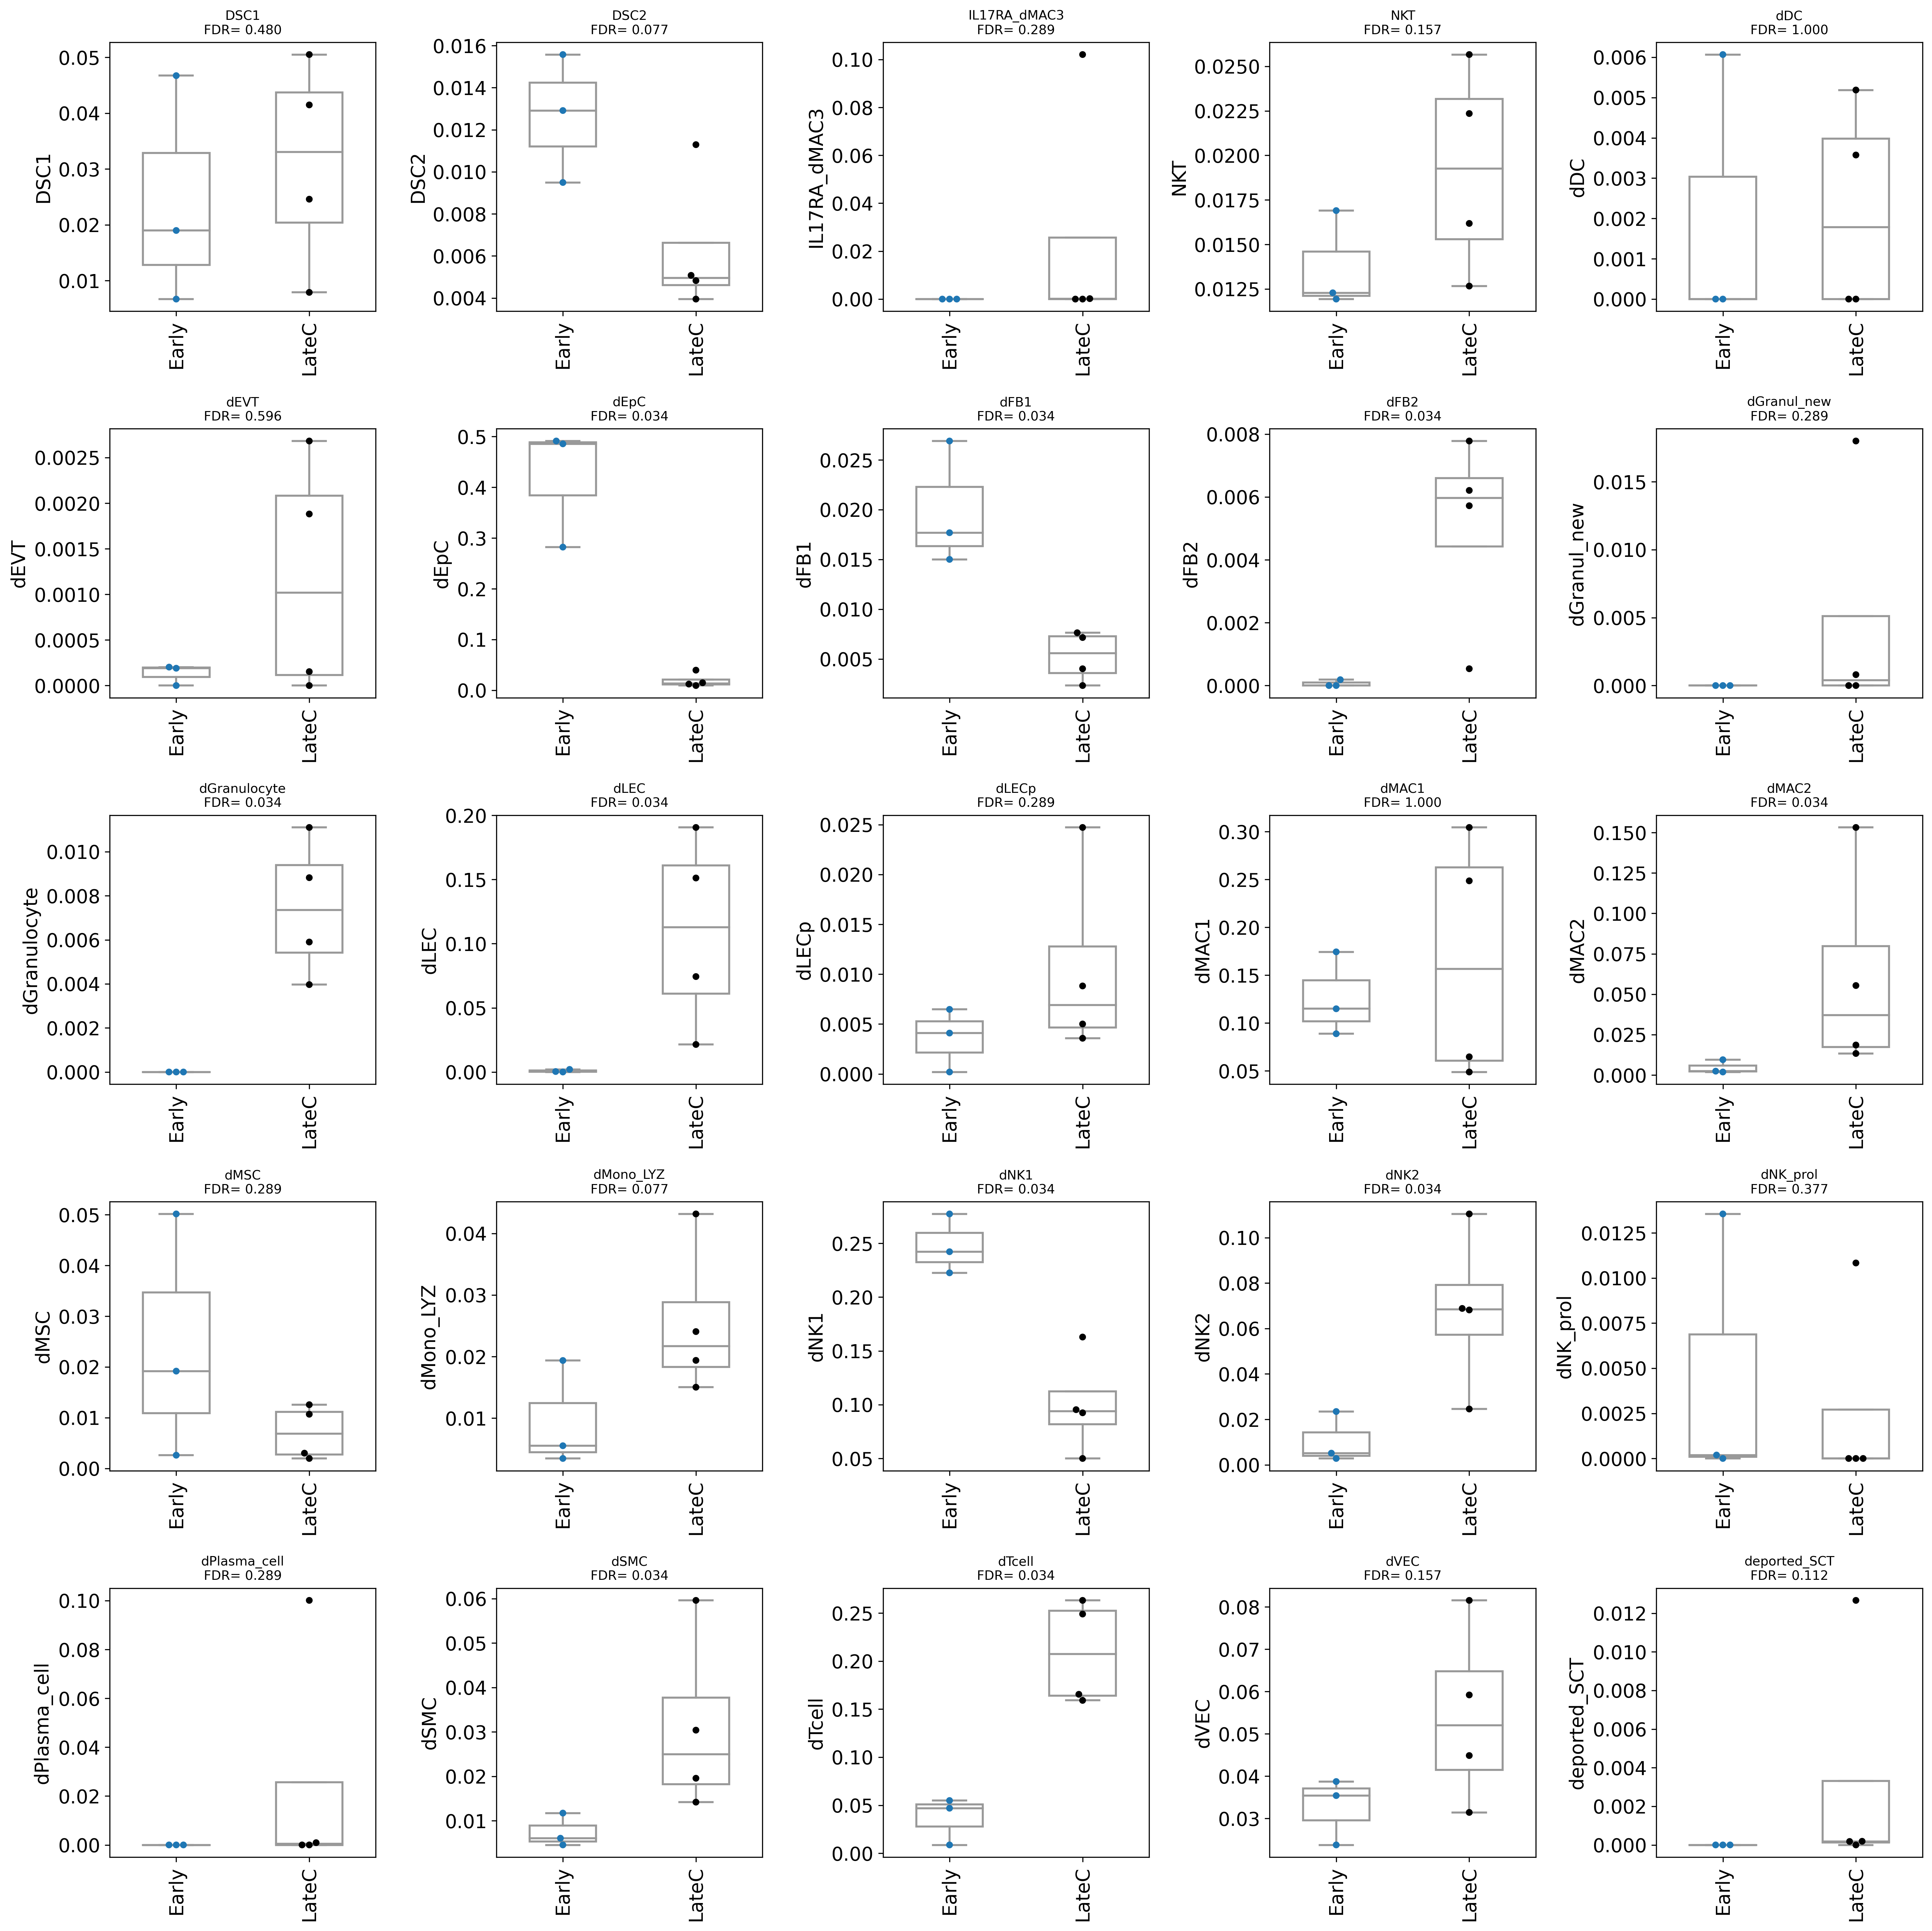

In [66]:
#For early vs term controls (all cell types included before filtering): 
make_abundance_plots(adata_control, 
                    groupby_annotation= 'condition_reordered', anno_subsets= 'celltype_v5')

In [67]:
#Rename the clusters a/c to current manuscript annotations: 
adata_pe.obs['celltype_annotations']= adata_pe.obs['celltype_v5'].map(lambda x: {"IL17RA_dMAC3": "dMono2",
"dMono_LYZ": "dMono1", "deported_SCT": "dDSTB", "dNK_prol": "dNKp", "dPlasma_cell": "dPlasmaC", "dGranulocyte": "dGranul",
"dGranul_new": "dBcell"}.get(x, x)).astype("category")

adata_pe.obs['celltype_annotations'].cat.categories

Trying to set attribute `.obs` of view, copying.


Index(['DSC1', 'DSC2', 'dMono2', 'NKT', 'dDC', 'dEVT', 'dEpC', 'dFB1', 'dFB2',
       'dBcell', 'dGranul', 'dLEC', 'dLECp', 'dMAC1', 'dMAC2', 'dMSC',
       'dMono1', 'dNK1', 'dNK2', 'dNKp', 'dPlasmaC', 'dSMC', 'dTcell', 'dVEC',
       'dDSTB'],
      dtype='object')

In [68]:
def dec_abundance_plots (adata, annotation_groupby = 'condition_reordered',
                          anno_subsets = 'celltype_v5',
                          donor_annot = 'donor_id_reordered',
                          save_file = 'Decidua_RA_PE_vs_term_v2_010422.pdf'):

    #Get number of categories (eoPE & term controls): 
    labels = adata.obs[annotation_groupby].cat.categories.tolist()
    n_labels = len(labels)
    subset_ids = adata.obs[anno_subsets].cat.categories.tolist()
    n_subsets = len(subset_ids)
    patient_ids = adata.obs[donor_annot].unique()
    n_patients = len(patient_ids)

    #Calculate subset fractions (cell-type/state per condition group): 
    subset_frac = pd.DataFrame(np.empty([n_patients, n_subsets]),
                                    index = patient_ids ,
                                    columns = subset_ids)
    for i in np.arange(n_patients):
        ind2 = adata.obs[donor_annot] == patient_ids[i]
        for j in np.arange(n_subsets):
            ind1 = adata.obs[anno_subsets] == subset_ids[j]
            subset_frac.iloc[i,j] = sum(ind1&ind2)
    subset_frac = subset_frac.apply(lambda x: x/sum(x),axis=1)

    #Get patient labels: 
    patient_phenos = pd.DataFrame(index = subset_frac.index, columns=[annotation_groupby])
    for i in range(0,len(labels)):
        p_list = adata.obs[donor_annot][adata.obs[annotation_groupby] == labels[i]].unique().tolist()
        patient_phenos[annotation_groupby][p_list] = labels[i]
    subset_frac_labeled = patient_phenos.join(subset_frac)
    subset_frac_labeled[annotation_groupby] = subset_frac_labeled[annotation_groupby].astype('category')
    subset_frac_labeled[annotation_groupby] = subset_frac_labeled[annotation_groupby].cat.reorder_categories(labels)
    subset_frac_labeled['PE'] = 'False'
    
    #Assign the PE samples. 
    subset_frac_labeled['PE'][subset_frac_labeled.index.isin(['Donor14_SP136', 'Donor15_SP136', 'Donor-274-decidua',
                                                             'Donor-389-decidua', 'Donor-419-decidua'])] = 'True'
    subset_frac_labeled[annotation_groupby] = subset_frac_labeled[annotation_groupby].astype('category')
    subset_frac_labeled[annotation_groupby] = subset_frac_labeled[annotation_groupby].cat.reorder_categories(labels)

    ##Make boxplots
    pvals = np.empty([n_labels-1,n_subsets])
    plt.figure(figsize=(20,4*math.ceil(n_subsets/5)))
    for i in np.arange(n_subsets):
        cluster_fracs = [[] for i in range(n_labels)]
        plt.subplot(math.ceil(n_subsets/5),5,i+1)
        for j in np.arange(n_labels):
            cluster_fracs[j] = subset_frac_labeled[subset_ids[i]][subset_frac_labeled[annotation_groupby]==labels[j]].values
        for j in np.arange(n_labels-1):    
            _, pvals[j,i] = stats.ranksums(cluster_fracs[0],cluster_fracs[j+1])
    
        sns.boxplot(x=annotation_groupby,y=subset_ids[i], data= subset_frac_labeled, fliersize=0, 
                    width= 0.5, color='white')
        sns.swarmplot(x=annotation_groupby, y=subset_ids[i], data= subset_frac_labeled[subset_frac_labeled['PE']=='False'],
                      size=5)
        sns.swarmplot(x=annotation_groupby, y=subset_ids[i], data= subset_frac_labeled[subset_frac_labeled['PE']=='True'],
                      color='k', size=5)
        
        plt.xticks(rotation=90)
        plt.xlabel(None)
        plt.grid(False, axis='both')
        _ , pvals[:,i], _ , _ = multipletests(pvals[:,i], method='fdr_bh') #Benjamini/Hochberg (non-negative)
    for i in np.arange(n_subsets):
        plt.subplot(math.ceil(n_subsets/5),5,i+1)
        plt.title(str(subset_ids[i])+'\n'+
                 "FDR= "+' '.join(['{:.3f}'.format(x) if x > 0.01 else '<.01' for x in pvals[:,i]]), fontsize=9.5)
    plt.tight_layout()
    plt.savefig(save_file) 

/home/debnatho/anaconda3/envs/scvi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/debnatho/anaconda3/envs/scvi_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


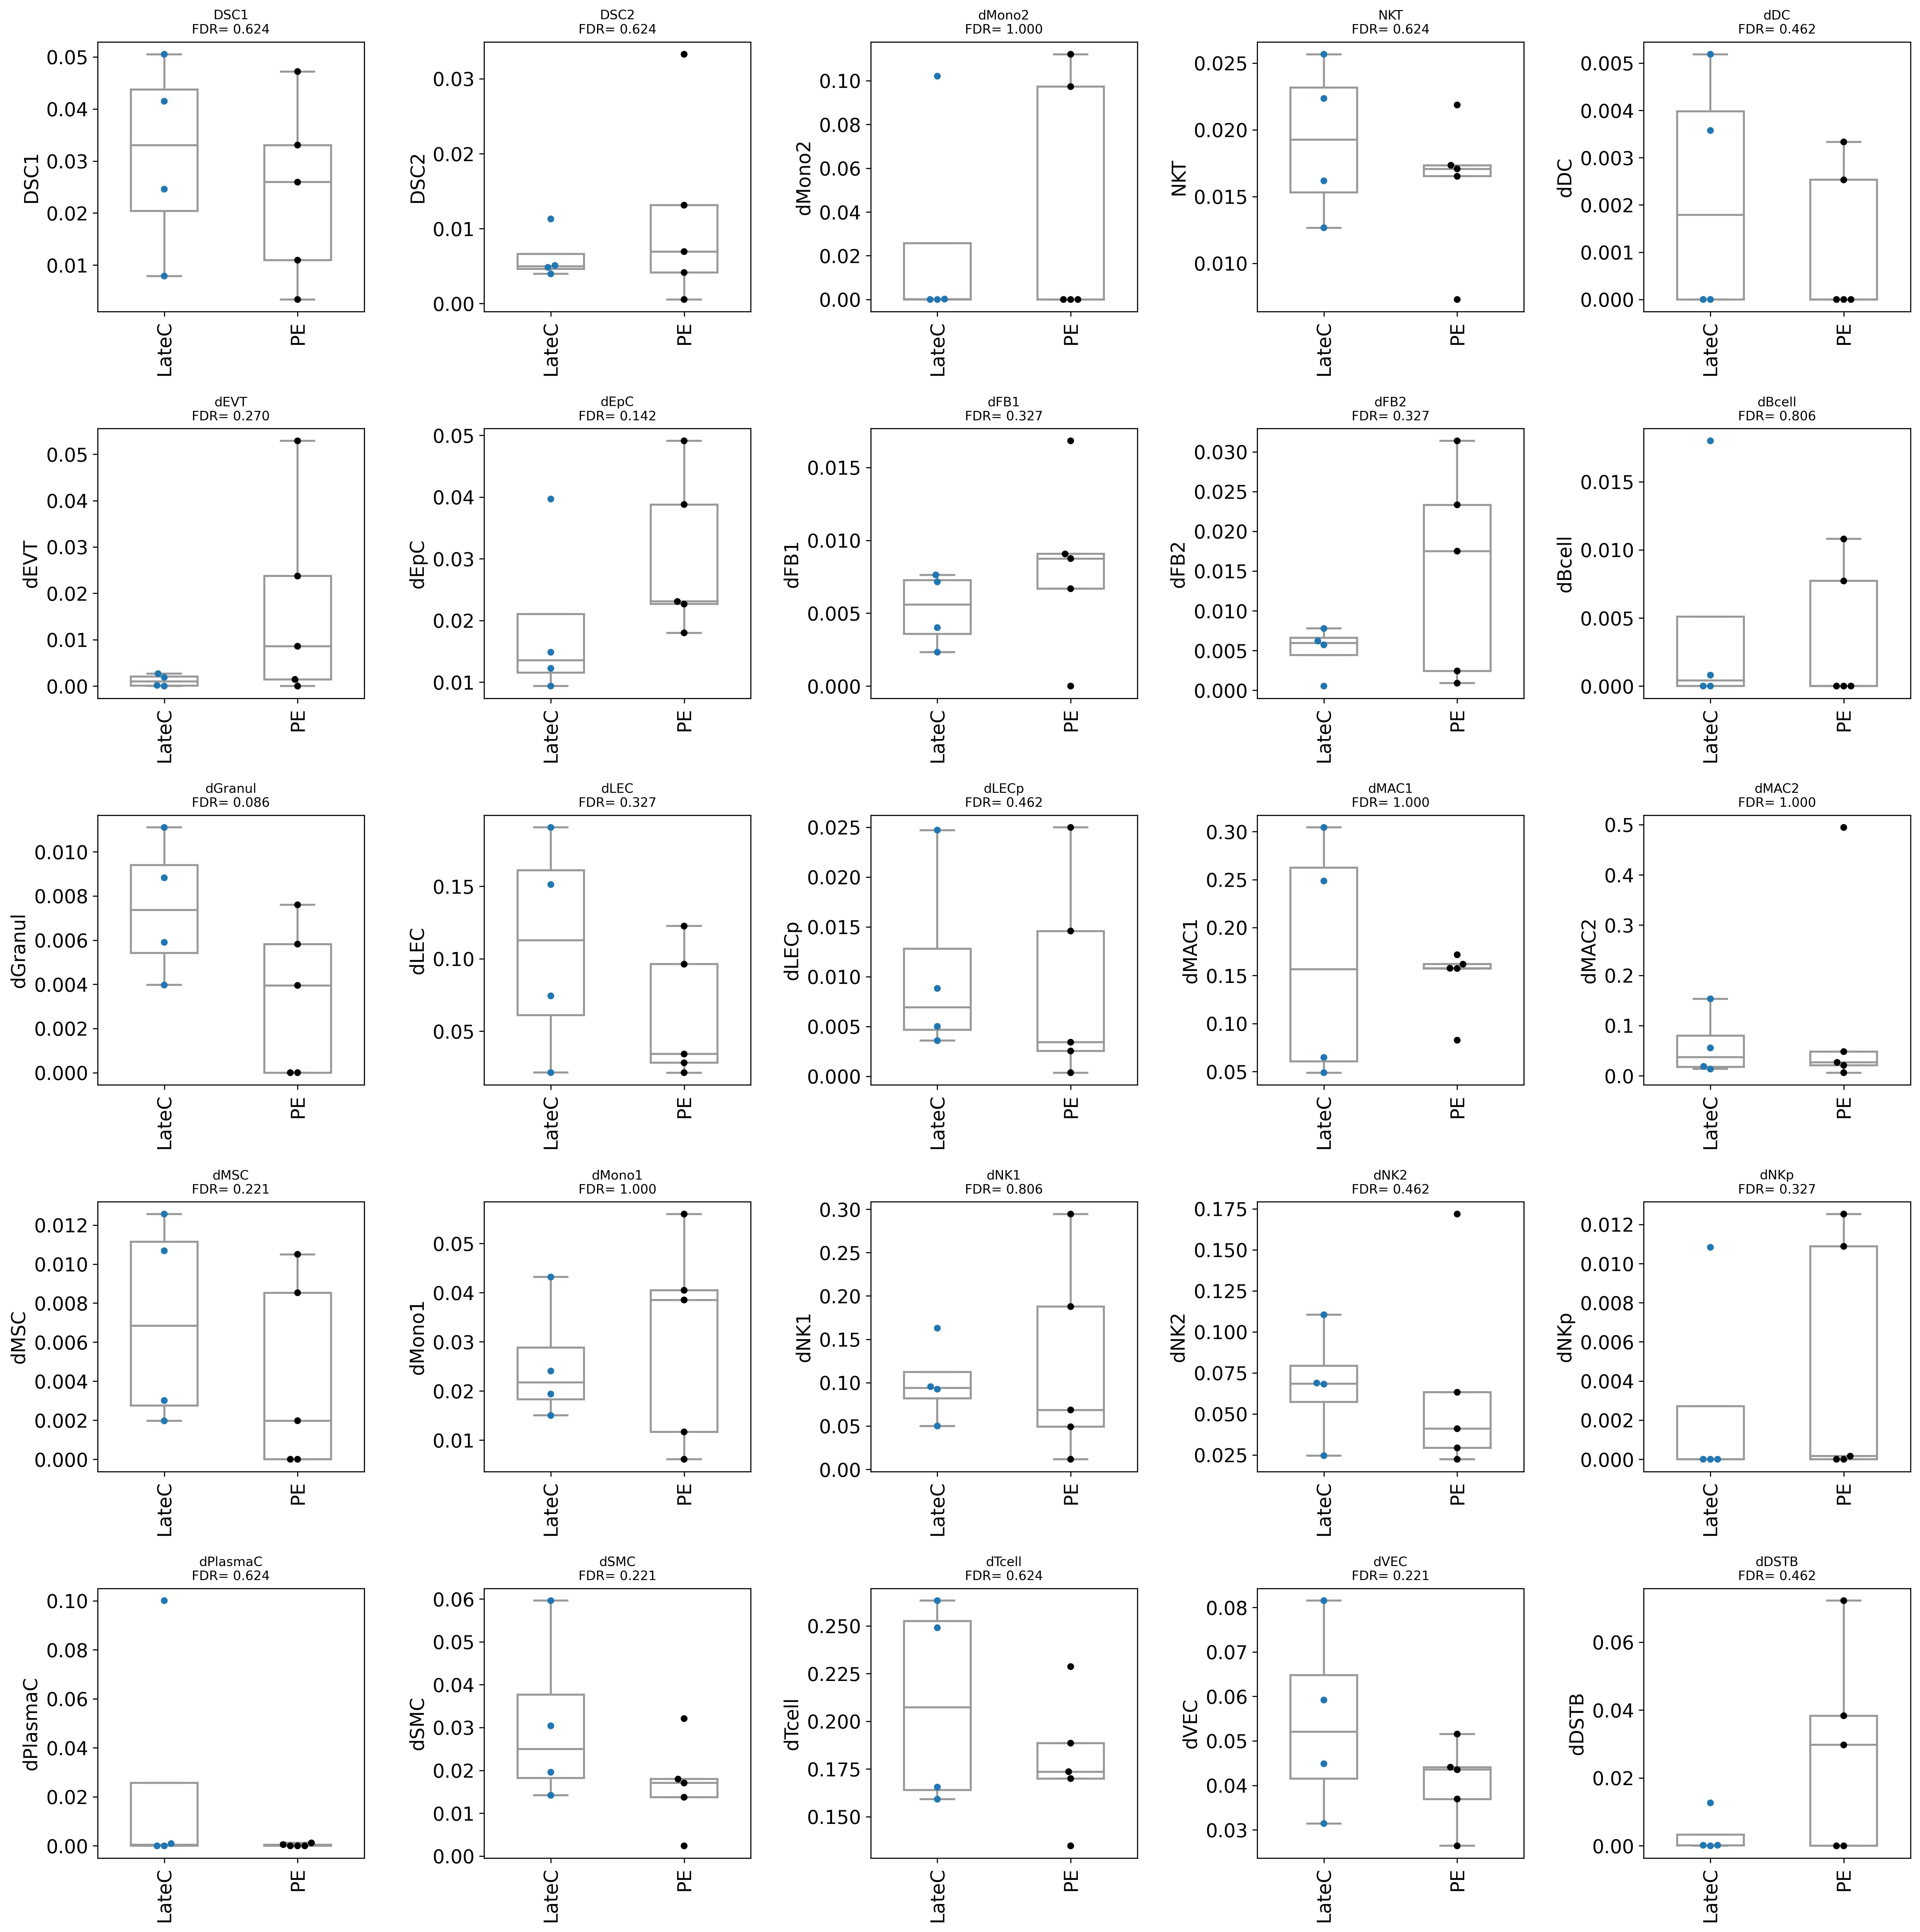

In [69]:
##Cell composition shift between eoPE & term controls is insignificant across clusters:
#However, this should be tested in a cohort with a higher sample size that influences the FDR. 
dec_abundance_plots(adata_pe, 
                annotation_groupby= 'condition_reordered', 
                anno_subsets= 'celltype_annotations')